### NOTE: this code is 99% similar to the code for MGX data, refer to that file for more detailed comments.

# Install and import packages

In [1]:
!pip install scikit-bio
!pip install shap
!pip install pymrmr
!pip install eli5
!pip install scikit-optimize
!pip install catboost==0.13
!pip install scikit-learn==0.23.2
!pip install lightgbm

In [430]:
# data representation
import pandas as pd
import numpy as np
import scipy.stats as sts

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

# feature engineering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import shap as sp
import pymrmr
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import f_classif, SelectFromModel
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# ML models
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.svm import SVC, LinearSVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# model metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score,\
        roc_curve, confusion_matrix, precision_recall_curve, auc, f1_score, precision_score, recall_score

# other
import skbio as sb
from tqdm import tqdm
import re



# Data import and pre-processing

## MGX data

In [2]:
# load the data
def get_omics(link):
    profile = pd.read_csv(link, delimiter='\t', header=0).T
    # get the names of all features
    names = profile.iloc[0, :]
    # rename columns
    profile.columns = names
    profile = profile.iloc[1:,:]
    profile = profile.reset_index(drop=False)
    profile.rename(columns = {'index': 'External ID'},  
          inplace = True)
    # sort the samples by sample ID
    profile = profile.sort_values(by='External ID', axis=0, ascending=True).reset_index(drop=True)
    
#     print(link)
#     print(profile.shape)
#     print(names)
#     print(profile.iloc[:5, :5])
    return profile.reset_index(drop=True), names

In [3]:
# get MTX pathways
mtx_path, mtx_path_names = get_omics('mtx_pathabundance_relab.tsv')

In [4]:
mtx_path.head()

# Pathway External ID 1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis  \
0            CSM5FZ4M                                           0.015748     
1            CSM5MCUO                                         0.00751257     
2            CSM5MCVN                                           0.025239     
3            CSM5MCW6                                          0.0170059     
4            CSM5MCWC                                         0.00201205     

# Pathway 1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis|g__Akkermansia.s__Akkermansia_muciniphila  \
0                                                          0                                               
1                                                          0                                               
2                                                          0                                               
3                                                          0                                               
4                                                          0                                               

# Pathway 1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis|g__Bacteroides.s__Bacteroides_barnesiae  \
0                                                          0                                             
1                                                          0                                             
2                                                          0                                             
3                                                          0                                             
4                                                          0                                             

# Pathway 1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis|g__Bacteroides.s__Bacteroides_caccae  \
0                                                          0                                          
1                                                          0                                          
2                                                          0                                          
3                                                          0                                          
4                                                          0                                          

# Pathway 1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis|g__Bacteroides.s__Bacteroides_cellulosilyticus  \
0                                                          0                                                    
1                                                          0                                                    
2                                                          0                                                    
3                                                          0                                                    
4                                                          0                                                    

# Pathway 1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis|g__Bacteroides.s__Bacteroides_clarus  \
0                                                          0                                          
1                                                          0                                          
2                                                          0                                          
3                                                          0                                          
4                                                          0                                          

# Pathway 1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis|g__Bacteroides.s__Bacteroides_coprocola  \
0                                                          0                                             
1                                                          0                                             
2         

In [172]:
mtx_path_copy = mtx_path.copy()

In [173]:
paths = []
for col in mtx_path.columns:
    if '|' not in col:
        paths.append(col)
        
mtx_path_copy = (mtx_path_copy[paths[1:]].reset_index(drop=True)).astype('float64')
mtx_path_copy['External ID'] = mtx_path['External ID']

In [174]:
mtx_path_copy.head()

# Pathway  1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis  \
0                                                   0.015748      
1                                                   0.007513      
2                                                   0.025239      
3                                                   0.017006      
4                                                   0.002012      

# Pathway  3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation  \
0                                                        0.0                            
1                                                        0.0                            
2                                                        0.0                            
3                                                        0.0                            
4                                                        0.0                            

# Pathway  7ALPHADEHYDROX-PWY: cholate degradation (bacteria, anaerobic)  \
0                                                   0.000000               
1                                                   0.000000               
2                                                   0.000834               
3                                                   0.000000               
4                                                   0.000000               

# Pathway  AEROBACTINSYN-PWY: aerobactin biosynthesis  \
0                                                 0.0   
1                                                 0.0   
2                                                 0.0   
3                                                 0.0   
4                                                 0.0   

# Pathway  ALL-CHORISMATE-PWY: superpathway of chorismate metabolism  \
0                                                        0.0           
1                                                        0.0           
2                                                        0.0           
3                                                        0.0           
4                                                        0.0           

# Pathway  ALLANTOINDEG-PWY: superpathway of allantoin degradation in yeast  \
0                                                        0.0                  
1                                                        0.0                  
2                                                        0.0                  
3                                                        0.0                  
4                                                        0.0                  

# Pathway  ANAEROFRUCAT-PWY: homolactic fermentation  \
0                                           0.009075   
1                                           0.011427   
2                                           0.004849   
3                                           0.000000   
4                                           0.007918   

# Pathway  ANAGLYCOLYSIS-PWY: glycolysis III (from glucose)  \
0                                                  0.036794   
1                                                  0.029891   
2                                                  0.014303   
3                                                  0.008145   
4                                                  0.019292   

# Pathway  ARG+POLYAMINE-SYN: superpathway of arginine and polyamine biosynthesis  \
0                                                   0.000000                        
1                                                   0.000000                        
2                                                   0.000000                        
3                                                   0.000000                        
4                                                   0.001385                        

# Pathway  ARGDEG-PWY: superpathway of L-arginine, putrescine, and 4-aminobutanoate degradation  \
0                           

## Metadata

In [175]:
# import metadata
metadata = pd.read_csv('hmp2_metadata.csv')
metadata['diseased'] = metadata['diagnosis'].replace({'UC': 1, 'CD': 1, 'nonIBD': 0})

Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types.Specify dtype option on import or set low_memory=False.


In [176]:
# metadata head
metadata.iloc[:10, :10].head()

Project External ID Participant ID site_sub_coll   data_type  \
0  C3001CSC1_BP      206615          C3001     C3001CSC1  biopsy_16S   
1  C3001CSC2_BP      206614          C3001     C3001CSC2  biopsy_16S   
2  C3002CSC1_BP      206617          C3002     C3002CSC1  biopsy_16S   
3  C3002CSC2_BP      206619          C3002     C3002CSC2  biopsy_16S   
4  C3002CSC3_BP      206616          C3002     C3002CSC3  biopsy_16S   

   week_num date_of_receipt  interval_days  visit_num Research Project  
0       2.0             NaN            NaN          1           ibdmdb  
1       2.0             NaN            NaN          1           ibdmdb  
2       0.0             NaN            NaN          1           ibdmdb  
3       0.0             NaN            NaN          1           ibdmdb  
4       0.0             NaN            NaN          1           ibdmdb

In [177]:
# check out metadata columns
metadata.columns

Index(['Project', 'External ID', 'Participant ID', 'site_sub_coll',
       'data_type', 'week_num', 'date_of_receipt', 'interval_days',
       'visit_num', 'Research Project',
       ...
       'Proteomics received at LBNL:', 'Stool Sample ID:  Tube A  (EtOH)',
       'Sample ID: Tube B (No preservative)',
       'Tube A and B received at Broad:', 'stool_id', 'smoking status',
       'Number years smoked', 'Age when started smoking',
       'How many cigarettes/cigars/etc. do you smoke per day?', 'diseased'],
      dtype='object', length=491)

In [178]:
# get microbiome data types, such as 16S, MGX, MTX,...
data_types = metadata['data_type'].unique()

In [179]:
# get the particular metadata for each data type
def get_meta(data):
    meta = metadata[metadata['data_type'] == data]
    # sort metadata by sample ID
    meta = meta.sort_values(by='External ID', axis=0, ascending=True).reset_index(drop=True)
#     print('# of samples', meta.shape[0])
#     print('# of participants', len(meta['Participant ID'].unique()))
#     print('# of diseased', meta['diagnosis'].value_counts(normalize=True))
    return meta

In [180]:
# get and inspect each type of data
meta = {}
for each in data_types:
#     print(each)
    meta[each] = get_meta(each)

## Combined data

In [181]:
data_types

array(['biopsy_16S', 'host_genome', 'host_transcriptomics',
       'metabolomics', 'metagenomics', 'metatranscriptomics', 'methylome',
       'proteomics', 'serology', 'stool_16S', 'viromics'], dtype=object)

In [182]:
# assign each metadata subset to a variable
mgx_meta = meta['metagenomics']
mtx_meta = meta['metatranscriptomics']
mbx_meta = meta['metabolomics']
mvx_meta = meta['viromics']

In [183]:
mtx_meta = mtx_meta.sort_values('External ID', axis=0)
mtx_meta.head()

Project External ID Participant ID site_sub_coll            data_type  \
0  G89301  CSM5FZ3T_P          C3002       C3002C1  metatranscriptomics   
1  G89347  CSM5FZ46_P          C3002       C3002C6  metatranscriptomics   
2  G89308  CSM5FZ4C_P          C3001       C3001C5  metatranscriptomics   
3  G89324  CSM5FZ4G_P          C3003       C3003C3  metatranscriptomics   
4  G89340  CSM5FZ4K_P          C3003       C3003C5  metatranscriptomics   

   week_num date_of_receipt  interval_days  visit_num Research Project  ...  \
0       0.0      2014-04-29            0.0          4           ibdmdb  ...   
1      10.0      2014-07-08           14.0          9           ibdmdb  ...   
2       8.0      2014-05-09           11.0          8           ibdmdb  ...   
3       3.0      2014-06-03           11.0          6           ibdmdb  ...   
4       7.0      2014-07-01           14.0          8           ibdmdb  ...   

  Proteomics received at LBNL:  Stool Sample ID:  Tube A  (EtOH)  \
0                           No                          SM-5FZ3T   
1                           No                          SM-5FZ46   
2                           No                          SM-5FZ4C   
3                           No                          SM-5FZ4G   
4                           No                          SM-5FZ4K   

  Sample ID: Tube B (No preservative) Tube A and B received at Broad:  \
0                            SM-5FZ3U                             Yes   
1                            SM-5FZ47                              No   
2                            SM-5FZ4D                             Yes   
3                            SM-5FZ4H                              No   
4                            SM-5FZ4L                              No   

  stool_id  smoking status  Number years smoked  Age when started smoking  \
0      NaN             NaN                  NaN                       NaN   
1      NaN             NaN                  NaN                       NaN   
2      NaN             NaN                  NaN                       NaN   
3      NaN             NaN                  NaN                       NaN   
4      NaN             NaN                  NaN                       NaN   

   How many cigarettes/cigars/etc. do you smoke per day?  diseased  
0                                                NaN             1  
1                                                NaN             1  
2                                                NaN             1  
3                                                NaN             1  
4                                                NaN             1  

[5 rows x 491 columns]

In [184]:
# merge MTX pathways with metadata
mtx_path_d = pd.merge(mtx_meta[['External ID', 'Participant ID', 'date_of_receipt', 'diseased']], mtx_path_copy,  on='External ID')
mtx_path_d = mtx_path_d.set_index('External ID')
mtx_path_d.iloc[:5, :10]

Participant ID date_of_receipt  diseased  \
External ID                                            
CSM5FZ4M             C3003      2014-07-16         1   
CSM5MCUO             C3006      2014-08-06         1   
CSM5MCVN             C3002      2014-08-19         1   
CSM5MCW6             C3008      2014-08-26         1   
CSM5MCWC             C3009      2014-08-19         1   

             1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis  \
External ID                                                         
CSM5FZ4M                                              0.015748      
CSM5MCUO                                              0.007513      
CSM5MCVN                                              0.025239      
CSM5MCW6                                              0.017006      
CSM5MCWC                                              0.002012      

             3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation  \
External ID                                                                               
CSM5FZ4M                                                   0.0                            
CSM5MCUO                                                   0.0                            
CSM5MCVN                                                   0.0                            
CSM5MCW6                                                   0.0                            
CSM5MCWC                                                   0.0                            

             7ALPHADEHYDROX-PWY: cholate degradation (bacteria, anaerobic)  \
External ID                                                                  
CSM5FZ4M                                              0.000000               
CSM5MCUO                                              0.000000               
CSM5MCVN                                              0.000834               
CSM5MCW6                                              0.000000               
CSM5MCWC                                              0.000000               

             AEROBACTINSYN-PWY: aerobactin biosynthesis  \
External ID                                               
CSM5FZ4M                                            0.0   
CSM5MCUO                                            0.0   
CSM5MCVN                                            0.0   
CSM5MCW6                                            0.0   
CSM5MCWC                                            0.0   

             ALL-CHORISMATE-PWY: superpathway of chorismate metabolism  \
External ID                                                              
CSM5FZ4M                                                   0.0           
CSM5MCUO                                                   0.0           
CSM5MCVN                                                   0.0           
CSM5MCW6                                                   0.0           
CSM5MCWC                                                   0.0           

             ALLANTOINDEG-PWY: superpathway of allantoin degradation in yeast  \
External ID                                                                     
CSM5FZ4M                                                   0.0                  
CSM5MCUO                                                   0.0                  
CSM5MCVN                                                   0.0                  
CSM5MCW6                                                   0.0                  
CSM5MCWC                                                   0.0                  

             ANAEROFRUCAT-PWY: homolactic fermentation  
External ID                                             
CSM5FZ4M                                      0.009075  
CSM5MCUO                                      0.011427  
CSM5MCVN                                      0.004849  
CSM5MCW6                                      0.000000  
CSM5MCWC                                      0.007918

In [185]:
mtx_path_d.shape

(735, 433)

In [186]:
reps = np.where(mtx_path_d.duplicated(['Participant ID', 'date_of_receipt']) == True)[0]
for i in list(reps):
    mtx_path_d.iloc[i-1,3:] = (mtx_path_d.iloc[i-1,3:] + mtx_path_d.iloc[i,3:]) / 2

In [187]:
mtx_path_d = mtx_path_d.drop(index = list(mtx_path_d.index[list(reps)]))

In [188]:
mtx_path_d.head()

Participant ID date_of_receipt  diseased  \
External ID                                            
CSM5FZ4M             C3003      2014-07-16         1   
CSM5MCUO             C3006      2014-08-06         1   
CSM5MCVN             C3002      2014-08-19         1   
CSM5MCW6             C3008      2014-08-26         1   
CSM5MCWC             C3009      2014-08-19         1   

             1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis  \
External ID                                                         
CSM5FZ4M                                              0.015748      
CSM5MCUO                                              0.007513      
CSM5MCVN                                              0.025239      
CSM5MCW6                                              0.017006      
CSM5MCWC                                              0.002012      

             3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation  \
External ID                                                                               
CSM5FZ4M                                                   0.0                            
CSM5MCUO                                                   0.0                            
CSM5MCVN                                                   0.0                            
CSM5MCW6                                                   0.0                            
CSM5MCWC                                                   0.0                            

             7ALPHADEHYDROX-PWY: cholate degradation (bacteria, anaerobic)  \
External ID                                                                  
CSM5FZ4M                                              0.000000               
CSM5MCUO                                              0.000000               
CSM5MCVN                                              0.000834               
CSM5MCW6                                              0.000000               
CSM5MCWC                                              0.000000               

             AEROBACTINSYN-PWY: aerobactin biosynthesis  \
External ID                                               
CSM5FZ4M                                            0.0   
CSM5MCUO                                            0.0   
CSM5MCVN                                            0.0   
CSM5MCW6                                            0.0   
CSM5MCWC                                            0.0   

             ALL-CHORISMATE-PWY: superpathway of chorismate metabolism  \
External ID                                                              
CSM5FZ4M                                                   0.0           
CSM5MCUO                                                   0.0           
CSM5MCVN                                                   0.0           
CSM5MCW6                                                   0.0           
CSM5MCWC                                                   0.0           

             ALLANTOINDEG-PWY: superpathway of allantoin degradation in yeast  \
External ID                                                                     
CSM5FZ4M                                                   0.0                  
CSM5MCUO                                                   0.0                  
CSM5MCVN                                                   0.0                  
CSM5MCW6                                                   0.0                  
CSM5MCWC                                                   0.0                  

             ANAEROFRUCAT-PWY: homolactic fermentation  ...  \
External ID                                             ...   
CSM5FZ4M                                      0.009075  ...   
CSM5MCUO                                      0.011427  ...   
CSM5MCVN                                      0.004849  ...   
CSM5MCW6                                      0.000000  ...   
CSM5MCWC                                      0.007918  ...   

       

# Preliminary analysis

## Distribution of number of samples

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


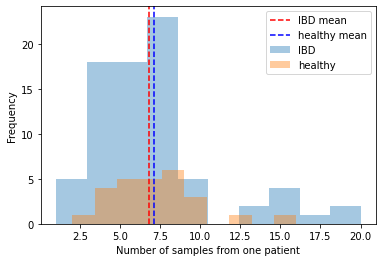

In [189]:
sns.distplot(mtx_path_d[['Participant ID', 'diseased']][mtx_path_d['diseased']==1].groupby('Participant ID').count()['diseased'],bins=10,kde=False, hist=True, label='IBD')
sns.distplot(mtx_path_d[['Participant ID', 'diseased']][mtx_path_d['diseased']==0].groupby('Participant ID').count()['diseased'],bins=10,kde=False, hist=True, label='healthy')
plt.axvline(np.mean(mtx_path_d[['Participant ID', 'diseased']][mtx_path_d['diseased']==1].groupby('Participant ID').count()['diseased']), label='IBD mean', color='red', linestyle='--')
plt.axvline(np.mean(mtx_path_d[['Participant ID', 'diseased']][mtx_path_d['diseased']==0].groupby('Participant ID').count()['diseased']), label='healthy mean', color='blue', linestyle='--')
plt.xlabel('Number of samples from one patient')
plt.ylabel('Frequency')
plt.legend()

In [190]:
count_samples_diseased = mtx_path_d[['Participant ID', 'diseased']][mtx_path_d['diseased']==1].groupby('Participant ID').count()
few_samples = list(count_samples_diseased[count_samples_diseased['diseased'] < 5].index)       
# few_samples                                     

In [191]:
mtx_path_d_reduced = mtx_path_d[~mtx_path_d['Participant ID'].isin(few_samples)]
X_all = mtx_path_d_reduced.drop(columns=['diseased', 'date_of_receipt'])
y_all = mtx_path_d_reduced[['Participant ID', 'diseased']]

In [192]:
print('Number of diseased participants')
mtx_path_d_reduced[['Participant ID', 'diseased']][mtx_path_d_reduced['diseased']==1].groupby('Participant ID').first()['diseased'].shape[0]

Number of diseased participants


55

In [193]:
print('Number of healthy participants')
mtx_path_d_reduced[['Participant ID', 'diseased']][mtx_path_d_reduced['diseased']==0].groupby('Participant ID').first()['diseased'].shape[0]

Number of healthy participants


26

In [194]:
print('Number of diseased and healthy samples')
y_all['diseased'].value_counts()

Number of diseased and healthy samples


1    460
0    184
Name: diseased, dtype: int64

In [195]:
mtx_path_d = mtx_path_d_reduced.drop(columns=['date_of_receipt'])

In [269]:
cols_match = {}
new_cols_ = []
for column in X_all.columns:
    new_column = re.sub(r'[",:{}[\]]', '', column)
    new_cols_.append(new_column)
    cols_match[new_column] = column
    
X_all.columns = new_cols_

## Overall abundance of all genera

In [196]:
mtx_path_d.head(3)

Participant ID  diseased  \
External ID                            
CSM5MCWC             C3009         1   
CSM5MCWE             C3009         1   
CSM5MCXH             C3004         1   

             1CMET2-PWY: N10-formyl-tetrahydrofolate biosynthesis  \
External ID                                                         
CSM5MCWC                                              0.002012      
CSM5MCWE                                              0.002018      
CSM5MCXH                                              0.020182      

             3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation  \
External ID                                                                               
CSM5MCWC                                                   0.0                            
CSM5MCWE                                                   0.0                            
CSM5MCXH                                                   0.0                            

             7ALPHADEHYDROX-PWY: cholate degradation (bacteria, anaerobic)  \
External ID                                                                  
CSM5MCWC                                                   0.0               
CSM5MCWE                                                   0.0               
CSM5MCXH                                                   0.0               

             AEROBACTINSYN-PWY: aerobactin biosynthesis  \
External ID                                               
CSM5MCWC                                            0.0   
CSM5MCWE                                            0.0   
CSM5MCXH                                            0.0   

             ALL-CHORISMATE-PWY: superpathway of chorismate metabolism  \
External ID                                                              
CSM5MCWC                                                   0.0           
CSM5MCWE                                                   0.0           
CSM5MCXH                                                   0.0           

             ALLANTOINDEG-PWY: superpathway of allantoin degradation in yeast  \
External ID                                                                     
CSM5MCWC                                                   0.0                  
CSM5MCWE                                                   0.0                  
CSM5MCXH                                                   0.0                  

             ANAEROFRUCAT-PWY: homolactic fermentation  \
External ID                                              
CSM5MCWC                                      0.007918   
CSM5MCWE                                      0.014045   
CSM5MCXH                                      0.002871   

             ANAGLYCOLYSIS-PWY: glycolysis III (from glucose)  ...  \
External ID                                                    ...   
CSM5MCWC                                             0.019292  ...   
CSM5MCWE                                             0.019823  ...   
CSM5MCXH                                             0.009026  ...   

             THRESYN-PWY: superpathway of L-threonine biosynthesis  \
External ID                                                          
CSM5MCWC                                              0.005725       
CSM5MCWE                                              0.005804       
CSM5MCXH                                              0.009858       

             TRIGLSYN-PWY: diacylglycerol and triacylglycerol biosynthesis  \
External ID                                                                  
CSM5MCWC                                                   0.0               
CSM5MCWE                                                   0.0               
CSM5MCXH                                                   0.0               

             TRNA-CHARGING-PWY: tRNA charging  \
External ID                                     
CSM5MCWC                             0.000000   
CSM5MCWE      

[Text(0.5, 1.0, '20 most abundant pathways')]

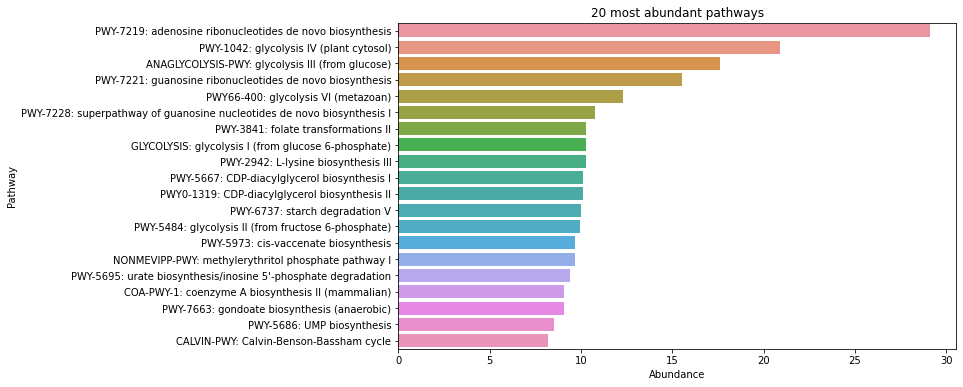

In [197]:
# See overall abundance of each genus
df = pd.DataFrame(mtx_path_d.drop(columns=['Participant ID', 'diseased']).sum(axis=0).sort_values(ascending=False)).reset_index()
df.columns = ['Pathway', 'Abundance']
plt.figure(figsize=(10,6))
sns.barplot(data = df.iloc[:20], y = 'Pathway', x = 'Abundance', orient = 'h').set(title=f'20 most abundant pathways')

[Text(0.5, 1.0, '20 most abundant pathway for healthy')]

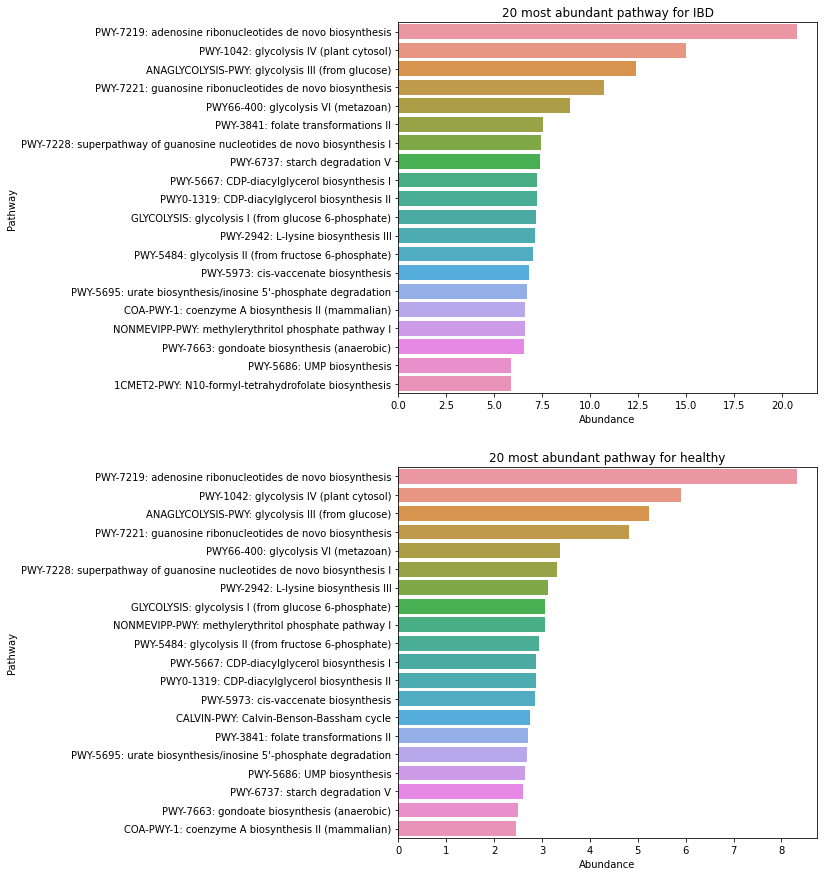

In [198]:
# See overall abundance of each genus in each class
df1 = pd.DataFrame(mtx_path_d[mtx_path_d['diseased']==1].drop(columns=['Participant ID', 'diseased']).sum(axis=0).sort_values(ascending=False)).reset_index()
df1.columns = ['Pathway', 'Abundance']
df0 = pd.DataFrame(mtx_path_d[mtx_path_d['diseased']==0].drop(columns=['Participant ID', 'diseased']).sum(axis=0).sort_values(ascending=False)).reset_index()
df0.columns = ['Pathway', 'Abundance']

plt.figure(figsize=(7.5,15))
plt.subplot(2,1,1)
sns.barplot(data = df1.iloc[:20], y = 'Pathway', x = 'Abundance', orient = 'h').set(title=f'20 most abundant pathway for IBD')
plt.subplot(2,1,2)
sns.barplot(data = df0.iloc[:20], y = 'Pathway', x = 'Abundance', orient = 'h').set(title=f'20 most abundant pathway for healthy')

In [440]:
print(df1['Pathway'][0])
print(df0['Pathway'][0])
print(df1['Pathway'][1:3])
print(df0['Pathway'][1:3])
print(df1['Pathway'][3])
print(df1['Pathway'][3])

PWY-7219: adenosine ribonucleotides de novo biosynthesis
PWY-7219: adenosine ribonucleotides de novo biosynthesis
1             PWY-1042: glycolysis IV (plant cytosol)
2    ANAGLYCOLYSIS-PWY: glycolysis III (from glucose)
Name: Pathway, dtype: object
1             PWY-1042: glycolysis IV (plant cytosol)
2    ANAGLYCOLYSIS-PWY: glycolysis III (from glucose)
Name: Pathway, dtype: object
PWY-7221: guanosine ribonucleotides de novo biosynthesis
PWY-7221: guanosine ribonucleotides de novo biosynthesis


## Distribution of some pathways

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


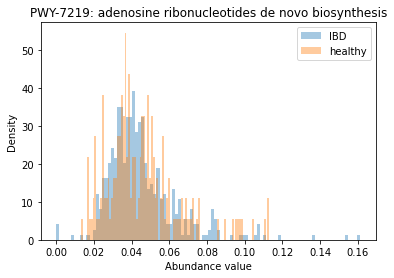

KstestResult(statistic=0.07608695652173914, pvalue=0.41571000843152417)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


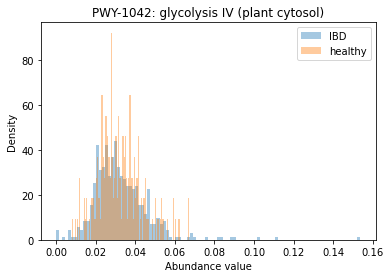

KstestResult(statistic=0.06956521739130435, pvalue=0.5298945540406277)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


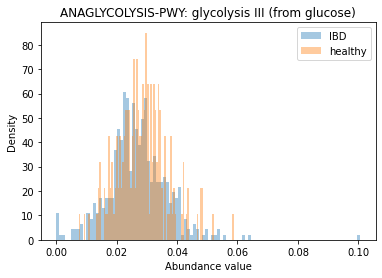

KstestResult(statistic=0.11413043478260869, pvalue=0.06115378825914408)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


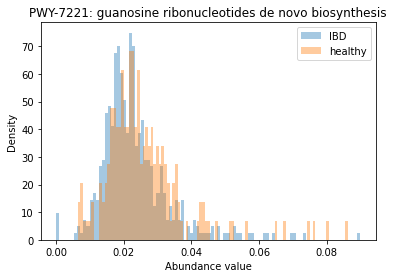

KstestResult(statistic=0.15978260869565217, pvalue=0.0021923601258765357)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


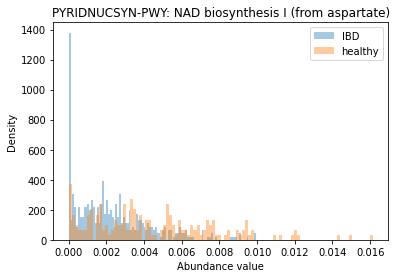

KstestResult(statistic=0.34130434782608693, pvalue=4.496403249731884e-14)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


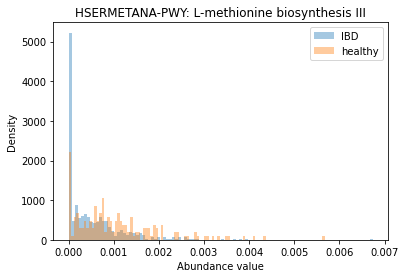

KstestResult(statistic=0.3282608695652174, pvalue=4.992672941739329e-13)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


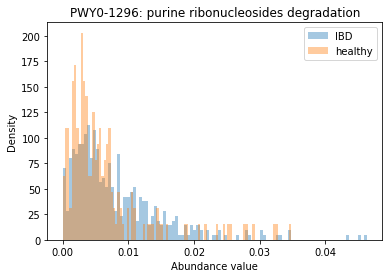

KstestResult(statistic=0.1923913043478261, pvalue=0.00010228722330651863)


In [441]:
# Plot the distribution of several genera
eps = 10**-100
def dist(g):
    plt.figure(figsize=(6,4))

    sns.distplot(mtx_path_d[mtx_path_d['diseased']==1][g],bins=100,kde=False, norm_hist=True, label='IBD')
    sns.distplot(mtx_path_d[mtx_path_d['diseased']==0][g],bins=100,kde=False, norm_hist=True, label='healthy')
    plt.title(g)
    plt.xlabel('Abundance value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    print(sts.kstest(mtx_path_d[mtx_path_d['diseased']==1][g], mtx_path_d[mtx_path_d['diseased']==0][g]))

dist('PWY-7219: adenosine ribonucleotides de novo biosynthesis')
dist('PWY-1042: glycolysis IV (plant cytosol)')
dist('ANAGLYCOLYSIS-PWY: glycolysis III (from glucose)')
dist('PWY-7221: guanosine ribonucleotides de novo biosynthesis')

dist('PYRIDNUCSYN-PWY: NAD biosynthesis I (from aspartate)')
dist('HSERMETANA-PWY: L-methionine biosynthesis III')
dist('PWY0-1296: purine ribonucleosides degradation')


# dist('g__Selenomonas')
# dist('g__Stomatobaculum')
# dist('g__Oribacterium')

# Classification pipeline

## Split and visualize data

### Split data

In [128]:
def patient_split(X, y):
    a = 1
    b = 1
    
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    while a/b > 3 or a/b < 2.5:
        
        patients = set(X['Participant ID'].unique())
        n = len(patients)
        train = set(np.random.choice(list(patients), int(np.ceil(n*np.random.uniform(2.5/4, 3/4))), replace=False))
        test = patients - train
        
        X_train, X_test, y_train, y_test =  X[X['Participant ID'].isin(train)], X[X['Participant ID'].isin(test)],\
        y[y['Participant ID'].isin(train)], y[y['Participant ID'].isin(test)]
        
        a = y_train['diseased'].value_counts().iloc[0]
        b = y_train['diseased'].value_counts().iloc[1]
        
    return X_train, X_test, y_train, y_test, list(X_train.index), list(X_test.index)

### PCA plot

In [133]:
# plot clustering of healthy and diseased
def plot_2d_space(X, y):
    y = y.to_numpy().ravel()

    # pca transform the features
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    colors = ['red', 'blue', 'black']
    markers = ['o', 's', 'x']

    # plot data in 2 dimensions
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X_pca[y==l, 0],
            X_pca[y==l, 1],
            c=c, label=l, marker=m
        )
        
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('PCA plot for data')
    plt.legend(loc='upper right')
    plt.show()

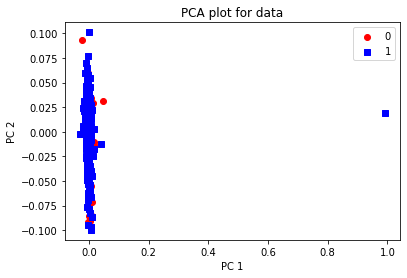

In [276]:
X_train_plot, X_test_plot, y_train_plot, y_test_plot, _, _ = patient_split(X_all, y_all)
plot_2d_space(X_train_plot.drop(columns=['Participant ID']), y_train_plot.drop(columns=['Participant ID']))

## Correlation & covariance

In [277]:
X_all['Participant ID'][y_all['diseased']==0].value_counts().iloc[:5]

P6018    16
M2072    13
M2061    10
M2039     9
M2041     9
Name: Participant ID, dtype: int64

In [278]:
X_all['Participant ID'][y_all['diseased']==1].value_counts().iloc[:5]

M2069    20
P6010    19
H4020    18
H4035    16
H4006    16
Name: Participant ID, dtype: int64

In [279]:
X_all.to_csv('X_all_path.csv')
y_all.to_csv('y_all_path.csv')

In [33]:
# X_all = pd.read_csv('X_all_path.csv')
# y_all = pd.read_csv('y_all_path.csv')

### Intrapatient correlation

Text(0.5, 1.0, 'Participant M2061, healthy')

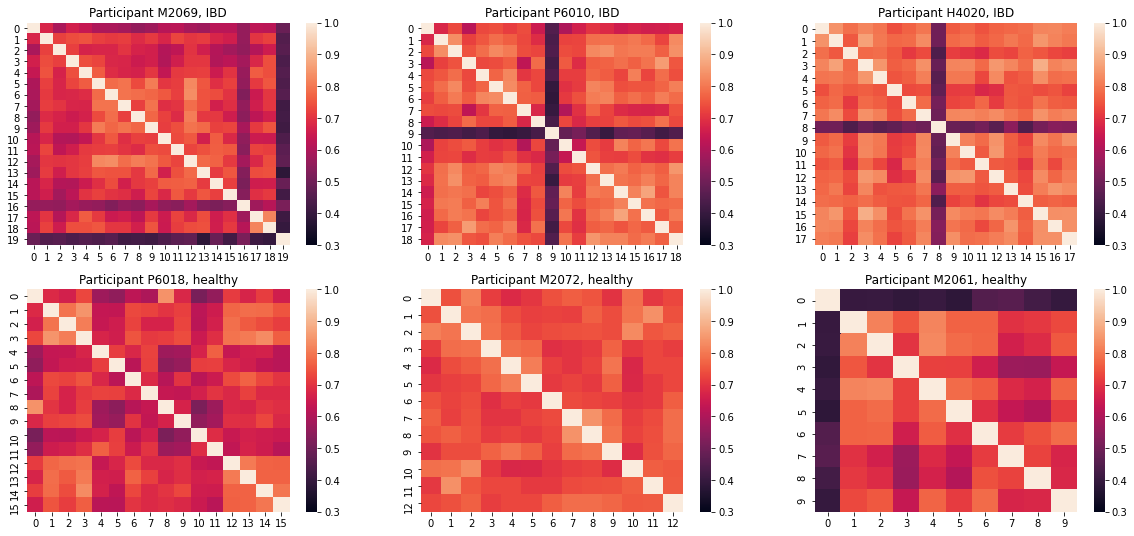

In [210]:
plt.figure(figsize=(20,9))

plt.subplot(2,3,1)
M2069 = X_all[X_all['Participant ID']=='M2069'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(M2069.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Participant M2069, IBD')

plt.subplot(2,3,2)
P6010 = X_all[X_all['Participant ID']=='P6010'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(P6010.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Participant P6010, IBD')

plt.subplot(2,3,3)
H4020 = X_all[X_all['Participant ID']=='H4020'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(H4020.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Participant H4020, IBD')

plt.subplot(2,3,4)
P6018 = X_all[X_all['Participant ID']=='P6018'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(P6018.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Participant P6018, healthy')

plt.subplot(2,3,5)
M2072 = X_all[X_all['Participant ID']=='M2072'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(M2072.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Participant M2072, healthy')

plt.subplot(2,3,6)
M2061 = X_all[X_all['Participant ID']=='M2061'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(M2061.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Participant M2061, healthy')

### Interpatient correlation

#### Sample means

Text(0.5, 1.0, 'Interpatient correlation for healthy, sample mean')

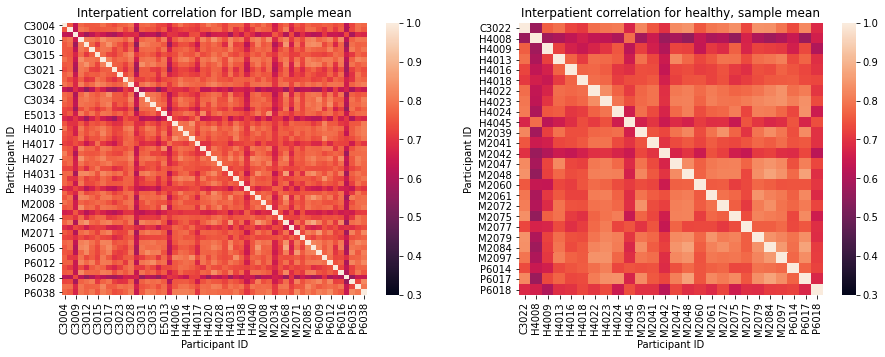

In [211]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
X_all_diseased_mean = X_all[y_all['diseased']==1].groupby(['Participant ID']).mean(numeric_only=False)
sns.heatmap(X_all_diseased_mean.T.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Interpatient correlation for IBD, sample mean')

plt.subplot(1,2,2)
X_all_healthy_mean = X_all[y_all['diseased']==0].groupby(['Participant ID']).mean(numeric_only=False)
sns.heatmap(X_all_healthy_mean.T.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Interpatient correlation for healthy, sample mean')

#### First sample

Text(0.5, 1.0, 'Interpatient correlation for healthy, first sample')

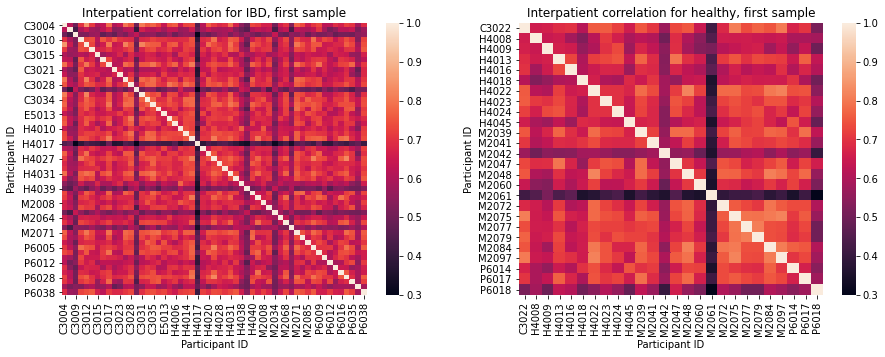

In [212]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
X_all_diseased_first = X_all[y_all['diseased']==1].groupby(['Participant ID']).first()
sns.heatmap(X_all_diseased_first.T.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Interpatient correlation for IBD, first sample')

plt.subplot(1,2,2)
X_all_healthy_first = X_all[y_all['diseased']==0].groupby(['Participant ID']).first()
sns.heatmap(X_all_healthy_first.T.corr(method='kendall'), annot=False, vmin=0.3, vmax=1.0)
plt.title('Interpatient correlation for healthy, first sample')

### Feature correlation

Text(0.5, 1.0, 'Pathway correlation for healthy, all samples')

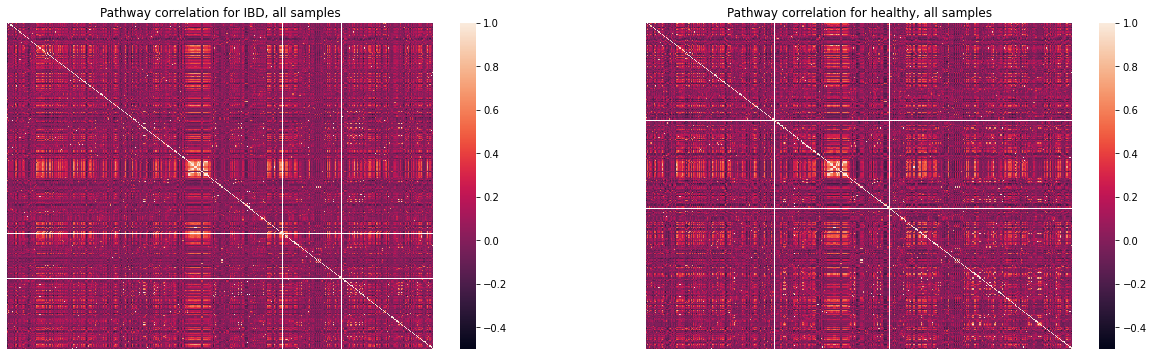

In [428]:
plt.figure(figsize=(21, 6))

# plt.figure()
plt.subplot(1,2,1)
X_all_diseased_all = X_all[y_all['diseased']==1]
sns.heatmap(X_all_diseased_all.corr(method='kendall'), xticklabels=False, yticklabels=False, annot=False, vmin=-0.5, vmax=1)
plt.title('Pathway correlation for IBD, all samples')

plt.subplot(1,2,2)
# plt.figure()
X_all_healthy_all = X_all[y_all['diseased']==0]
sns.heatmap(X_all_healthy_all.corr(method='kendall'), xticklabels=False, yticklabels=False, annot=False, vmin=-0.5, vmax=1)
plt.title('Pathway correlation for healthy, all samples')

In [216]:
# plt.figure(figsize=(21, 6))

# plt.subplot(1,2,1)
# X_all_diseased_mean = X_all[y_all['diseased']==1].groupby(['Participant ID']).mean(numeric_only=False)
# sns.heatmap(X_all_diseased_mean.corr(method='kendall'), annot=False)
# plt.title('Pathway correlation for IBD, sample mean')

# plt.subplot(1,2,2)
# X_all_healthy_mean = X_all[y_all['diseased']==0].groupby(['Participant ID']).mean(numeric_only=False)
# sns.heatmap(X_all_healthy_mean.corr(method='kendall'), annot=False)
# plt.title('Pathway correlation for healthy, sample mean')

In [217]:
# plt.figure(figsize=(20, 5))

# plt.subplot(1,2,1)
# X_all_diseased_first = X_all[y_all['diseased']==1].groupby(['Participant ID']).first()
# sns.heatmap(X_all_diseased_first.corr(method='kendall'), annot=False)
# plt.title('Pathway correlation for IBD, first sample')

# plt.subplot(1,2,2)
# X_all_healthy_first = X_all[y_all['diseased']==0].groupby(['Participant ID']).first()
# sns.heatmap(X_all_healthy_first.corr(method='kendall'), annot=False)
# plt.title('Pathway correlation for healthy, first sample')

## Feature selection

### Mutual info

In [219]:
def mutual_info(X, y, select_k):
    selection = SelectKBest(mutual_info_classif, k=select_k).fit(X, y)
    features = X.columns[selection.get_support()]
    return features

## Classification and evaluation

### Building models

#### Support vector classifier

In [385]:
def svc(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
#     for i in range(len(X_train_list)):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
        model = SVC(probability=True, kernel='linear', random_state=123)
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                    'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)

        if output == True:   
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print(prauc_mat)
            print(f1_mat)
            print(cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

#### Stochastic gradient descent classifier

In [386]:
# SGD
def sgd(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
#     for i in range(len(X_train_list)):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
        model = SGDClassifier(loss = 'modified_huber', penalty='elasticnet', alpha=0.0001, l1_ratio=0.5, random_state=123)
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                    'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print(prauc_mat)
            print(f1_mat)
            print(cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

#### Random forest classifier

In [363]:
def rfc_get_params(X_train, y_train, j):
    param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'log2'],
    'max_depth' : [7, 10]}

    rfc_ = RandomForestClassifier(random_state=123, class_weight='balanced')
#     grc = RandomizedSearchCV(rfc_, param_distributions=param_grid, cv=[patient_split(X_train, y_train)[4:] for i in range(j)])
#     grc = BayesSearchCV(rfc_, search_spaces=param_grid, cv=[patient_split(X_train, y_train)[4:] for i in range(j)])
    grc = GridSearchCV(rfc_, param_grid=param_grid, cv=[patient_split(X_train, y_train)[4:] for i in range(j)])

    grc.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
    params = grc.best_params_
    
    return params

def rfc(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
#     for i in range(len(X_train_list)):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
        params = rfc_get_params(X_train, y_train, j)
        model = RandomForestClassifier(random_state=123, max_features=params['max_features'],\
            n_estimators= params['n_estimators'], max_depth=params['max_depth'])
#         model = RandomForestClassifier(random_state=123, class_weight='balanced')
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print(prauc_mat)
            print(f1_mat)
            print(cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

def rfc2(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
#     for i in range(len(X_train_list)):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
#         params = rfc_get_params(X_train, y_train, j)
#         model = RandomForestClassifier(random_state=123, max_features=params['max_features'],\
#             n_estimators= params['n_estimators'], max_depth=params['max_depth'])
        model = RandomForestClassifier(random_state=123, class_weight='balanced')
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print(prauc_mat)
            print(f1_mat)
            print(cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

#### Gradient boosting classifier

In [364]:
def xgb_get_params(X_train, y_train, j):
    # cross validation for random forest classifier
    param_grid = { 
        'num_leaves': [20, 31, 50], 'max_depth':[5, 7], \
        'max_bin': [100, 255], 'min_data_in_leaf': [20, 100] 
    }

    xgb = LGBMClassifier(random_state=123, bagging_fraction=0.75, class_weight='balanced')
    grc = GridSearchCV(xgb, param_grid=param_grid, cv=[patient_split(X_train, y_train)[4:] for i in range(j)])
    grc.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
    params = grc.best_params_
    return params

def xgboost(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
#     for i in range(len(X_train_list)):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
            
#         X_train.columns = new_cols_
#         X_test.columns = new_cols_
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
        params = xgb_get_params(X_train, y_train, j)
        model = LGBMClassifier(random_state=123, bagging_fraction=0.75, class_weight = 'balanced',num_leaves = params['num_leaves'],\
                max_depth=params['max_depth'], min_data_in_leaf=params['min_data_in_leaf'], max_bin=params['max_bin'])
        
#         model = LGBMClassifier(random_state=123, class_weight = 'balanced')
#         model = GradientBoostingClassifier(random_state=123)
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
#         thres = [0.5]
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)

            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print('Precision recall AUC', prauc_mat)
            print('F1', f1_mat)
            print('Confusion matrix', cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
#     print(y_test_score_1)
    
    return models, best_f1_0_list, best_f1_1_list

def xgboost2(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
#     for i in range(len(X_train_list)):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
            
#         X_train.columns = new_cols_
#         X_test.columns = new_cols_
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
#         params = xgb_get_params(X_train, y_train, j)
#         model = LGBMClassifier(random_state=123, bagging_fraction=0.75, class_weight = 'balanced',num_leaves = params['num_leaves'],\
#                 max_depth=params['max_depth'], min_data_in_leaf=params['min_data_in_leaf'], max_bin=params['max_bin'])
        
        model = LGBMClassifier(random_state=123, class_weight = 'balanced')
#         model = GradientBoostingClassifier(random_state=123)
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
#         thres = [0.5]
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)

            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print('Precision recall AUC', prauc_mat)
            print('F1', f1_mat)
            print('Confusion matrix', cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
#     print(y_test_score_1)
    
    return models, best_f1_0_list, best_f1_1_list

### Model interpretation

In [332]:
# built-in feature importance
def tree_feat(X, y, model, k):
    l = len(X.columns)
    feats = np.argpartition(model.feature_importances_, -l)[-l:]
    df = pd.DataFrame()
    df['Feature'] = X.columns[feats]
    df['Importance Score'] = model.feature_importances_[feats]
    df = df.sort_values(['Importance Score'], axis=0, ascending=False)
#     plt.barh(df['feats'].iloc[(l-20):], df['scores'].iloc[(l-20):])
#     plt.show()
    
    plt.figure(figsize=(6, 4))
    sns.barplot(data = df.iloc[:k], y = 'Feature', x = 'Importance Score', orient = 'h',\
               ).set(title=f'{k} most important pathways')
    
    return df

def bestktree(df, k):
    return list(df.sort_values(['Importance Score'], axis=0, ascending=False)['Feature'].iloc[:k])

def shap_feat(X, y, model, j):
    sp.initjs()
    explainer = sp.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
#     shap.summary_plot(shap_values, X)
    sp.summary_plot(shap_values[1], X)
    
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    ls = list(feature_importance['col_name'])
    
    sp.dependence_plot(ls[0], shap_values[1], X)
    p = sp.force_plot(explainer.expected_value[1], shap_values[1][j], X.iloc[[j]])
    
    return p, shap_values

def bestkshap(X, shap_values, k):
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    ls = list(feature_importance['col_name'][:k])
    return ls

def linear_feat(X, y, model, j):
    l = len(X.columns)
    feats = np.argpartition(model.coef_[0], -l)[-l:]
    df = pd.DataFrame()
    X.columns[feats]
    df['Feature'] = X.columns[feats]
    df['Importance Score'] = np.abs(model.coef_[0][feats])
    df['Sign'] = [-1 if i < 0 else 1 for i in (model.coef_[0][feats])]
    df = df.sort_values(by='Importance Score', axis=0, ascending=False)
    df['Importance Score'] = df['Importance Score']*df['Sign']
    plt.figure(figsize=(6, 4))
    sns.barplot(data = df.iloc[:20], y = 'Feature', x = 'Importance Score', orient = 'h',\
               ).set(title=f'{20} most important pathways')
    return df

def bestklinear(df, k):
    return list(df['Feature'].iloc[:k])

In [413]:
def find_overlap(ls):
    all_entries = []
    for l in ls:
        all_entries.extend(list(l))
#     print(all_entries)
    all_entries_unique = set(all_entries)
#     print(all_entries_unique)
    all_entries_dict = {}

    for k in list(all_entries_unique):
        all_entries_dict[k] = all_entries.count(k)
        
    return all_entries_dict, [k for k, v in all_entries_dict.items() if v == max(all_entries_dict.values())]

# Implementation

In [409]:
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list  = []

for i in range(3):
    X_train_, X_test_, y_train_, y_test_, _, _ = patient_split(X_all, y_all)
    X_train_list.append(X_train_)
    X_test_list.append(X_test_)
    y_train_list.append(y_train_)
    y_test_list.append(y_test_)

In [407]:
for i in range(3):
    print(f'Split {i+1}')
    print('# IBD people', X_train_list[i][y_train_list[i]['diseased']==1].groupby('Participant ID').sum().shape[0])
    print('# healthy people', X_train_list[i][y_train_list[i]['diseased']==0].groupby('Participant ID').sum().shape[0])
    print('# IBD samples', y_train_list[i][y_train_list[i]['diseased']==1].shape[0])
    print('# healthy samples', y_train_list[i][y_train_list[i]['diseased']==0].shape[0])

Split 1
# IBD people 39
# healthy people 18
# IBD samples 328
# healthy samples 130
Split 2
# IBD people 41
# healthy people 20
# IBD samples 344
# healthy samples 131
Split 3
# IBD people 39
# healthy people 17
# IBD samples 329
# healthy samples 114


In [408]:
for i in range(3):
    print(f'Split {i+1}')
    print('# IBD people', X_test_list[i][y_test_list[i]['diseased']==1].groupby('Participant ID').sum().shape[0])
    print('# healthy people', X_test_list[i][y_test_list[i]['diseased']==0].groupby('Participant ID').sum().shape[0])
    print('# IBD samples', y_test_list[i][y_test_list[i]['diseased']==1].shape[0])
    print('# healthy samples', y_test_list[i][y_test_list[i]['diseased']==0].shape[0])

Split 1
# IBD people 16
# healthy people 8
# IBD samples 132
# healthy samples 54
Split 2
# IBD people 14
# healthy people 6
# IBD samples 116
# healthy samples 53
Split 3
# IBD people 16
# healthy people 9
# IBD samples 131
# healthy samples 70


In [284]:
# models_rfc, best_f1_0_list_rfc, best_f1_1_list_rfc = xgboost(X_train_list, X_test_list, y_train_list, y_test_list, j=5, output=True)

## Model performance with all features

  0%|          | 0/3 [00:00<?, ?it/s]

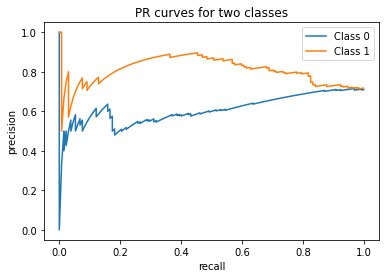

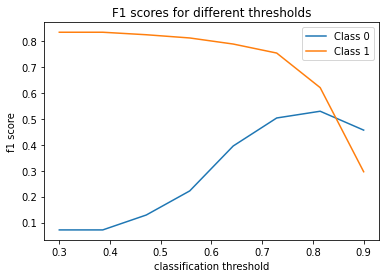

 33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

{'Class 0': '0.61', 'Class 1': '0.80'}
  Threshold   Class 0   Class 1
0     0.300  0.071429  0.835443
1     0.386  0.071429  0.835443
2     0.471  0.129032  0.825806
3     0.557  0.222222  0.813333
4     0.643  0.395833  0.789855
5     0.729  0.504065  0.755020
6     0.814  0.530120  0.621359
7     0.900  0.457143  0.296296
  Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[42, 88], [2, 326]]    [[2, 52], [0, 132]]
1     0.386       [[52, 78], [5, 323]]    [[2, 52], [0, 132]]
2     0.471      [[63, 67], [10, 318]]    [[4, 50], [4, 128]]
3     0.557      [[82, 48], [14, 314]]   [[8, 46], [10, 122]]
4     0.643      [[95, 35], [26, 302]]  [[19, 35], [23, 109]]
5     0.729     [[104, 26], [61, 267]]   [[31, 23], [38, 94]]
6     0.814    [[116, 14], [119, 209]]   [[44, 10], [68, 64]]
7     0.900      [[130, 0], [242, 86]]   [[48, 6], [108, 24]]


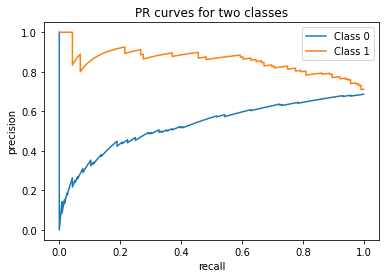

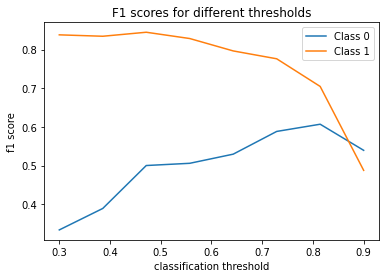

 67%|██████▋   | 2/3 [00:03<00:01,  1.63s/it]

{'Class 0': '0.53', 'Class 1': '0.86'}
  Threshold   Class 0   Class 1
0     0.300  0.333333  0.838235
1     0.386  0.388889  0.834586
2     0.471  0.500000  0.844961
3     0.557  0.505747  0.828685
4     0.643  0.529412  0.796610
5     0.729  0.588235  0.776256
6     0.814  0.606897  0.704663
7     0.900  0.539326  0.487500
  Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[57, 74], [5, 339]]   [[11, 42], [2, 114]]
1     0.386      [[71, 60], [11, 333]]   [[14, 39], [5, 111]]
2     0.471      [[82, 49], [16, 328]]   [[20, 33], [7, 109]]
3     0.557      [[96, 35], [25, 319]]  [[22, 31], [12, 104]]
4     0.643     [[103, 28], [36, 308]]   [[27, 26], [22, 94]]
5     0.729     [[116, 15], [57, 287]]   [[35, 18], [31, 85]]
6     0.814    [[121, 10], [101, 243]]    [[44, 9], [48, 68]]
7     0.900     [[127, 4], [209, 135]]    [[48, 5], [77, 39]]


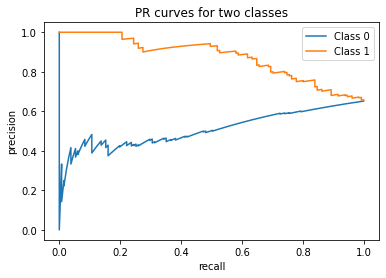

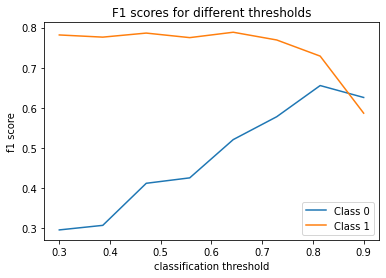

100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

{'Class 0': '0.51', 'Class 1': '0.87'}
  Threshold   Class 0   Class 1
0     0.300  0.294737  0.781759
1     0.386  0.306122  0.776316
2     0.471  0.411215  0.786441
3     0.557  0.424779  0.775087
4     0.643  0.520325  0.788530
5     0.729  0.577465  0.769231
6     0.814  0.655367  0.728889
7     0.900  0.625592  0.586387
  Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[54, 60], [6, 323]]  [[14, 56], [11, 120]]
1     0.386      [[60, 54], [11, 318]]  [[15, 55], [13, 118]]
2     0.471      [[68, 46], [13, 316]]  [[22, 48], [15, 116]]
3     0.557      [[71, 43], [21, 308]]  [[24, 46], [19, 112]]
4     0.643      [[78, 36], [29, 300]]  [[32, 38], [21, 110]]
5     0.729      [[87, 27], [47, 282]]  [[41, 29], [31, 100]]
6     0.814      [[93, 21], [81, 248]]   [[58, 12], [49, 82]]
7     0.900     [[105, 9], [191, 138]]    [[66, 4], [75, 56]]
Average best F1 for class 0:  0.5825558554688238
Average best F1 for class 1:  0.7533882256575769


In [295]:
models_svc, best_f1_0_list_svc, best_f1_1_list_svc = svc(X_train_list, X_test_list, y_train_list, y_test_list, j=5)

  0%|          | 0/3 [00:00<?, ?it/s]

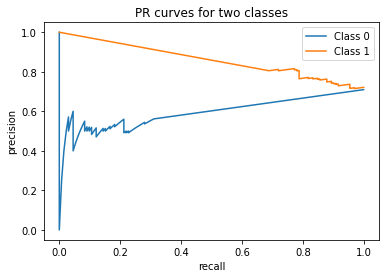

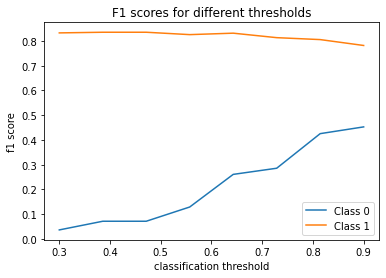

 33%|███▎      | 1/3 [00:01<00:02,  1.18s/it]

{'Class 0': '0.59', 'Class 1': '0.86'}
  Threshold   Class 0   Class 1
0     0.300  0.036364  0.832808
1     0.386  0.071429  0.835443
2     0.471  0.071429  0.835443
3     0.557  0.129032  0.825806
4     0.643  0.260870  0.831683
5     0.729  0.285714  0.813559
6     0.814  0.425532  0.805755
7     0.900  0.452830  0.781955
  Threshold Confusion matrix for train       Confusion matrix
0     0.300      [[22, 108], [0, 328]]    [[1, 53], [0, 132]]
1     0.386       [[34, 96], [2, 326]]    [[2, 52], [0, 132]]
2     0.471       [[44, 86], [2, 326]]    [[2, 52], [0, 132]]
3     0.557       [[52, 78], [5, 323]]    [[4, 50], [4, 128]]
4     0.643      [[66, 64], [10, 318]]    [[9, 45], [6, 126]]
5     0.729      [[79, 51], [16, 312]]  [[11, 43], [12, 120]]
6     0.814      [[89, 41], [25, 303]]  [[20, 34], [20, 112]]
7     0.900     [[100, 30], [36, 292]]  [[24, 30], [28, 104]]


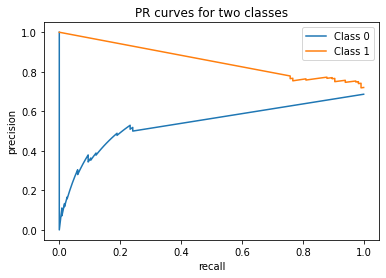

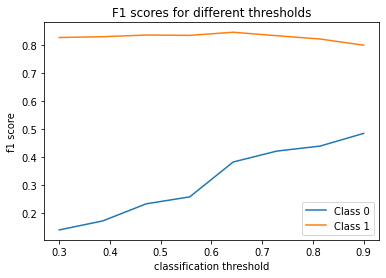

 67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

{'Class 0': '0.54', 'Class 1': '0.86'}
  Threshold   Class 0   Class 1
0     0.300  0.140351  0.825623
1     0.386  0.172414  0.828571
2     0.471  0.233333  0.834532
3     0.557  0.258065  0.833333
4     0.643  0.382353  0.844444
5     0.729  0.421053  0.832061
6     0.814  0.439024  0.820313
7     0.900  0.484211  0.798354
  Threshold Confusion matrix for train       Confusion matrix
0     0.300      [[12, 119], [0, 344]]    [[4, 49], [0, 116]]
1     0.386      [[16, 115], [0, 344]]    [[5, 48], [0, 116]]
2     0.471      [[26, 105], [1, 343]]    [[7, 46], [0, 116]]
3     0.557       [[41, 90], [4, 340]]    [[8, 45], [1, 115]]
4     0.643       [[55, 76], [6, 338]]   [[13, 40], [2, 114]]
5     0.729      [[70, 61], [12, 332]]   [[16, 37], [7, 109]]
6     0.814      [[87, 44], [25, 319]]  [[18, 35], [11, 105]]
7     0.900      [[99, 32], [41, 303]]   [[23, 30], [19, 97]]


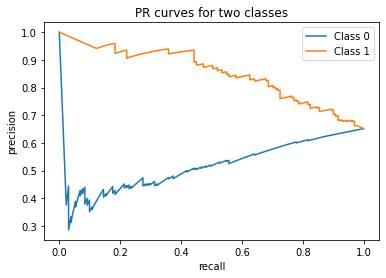

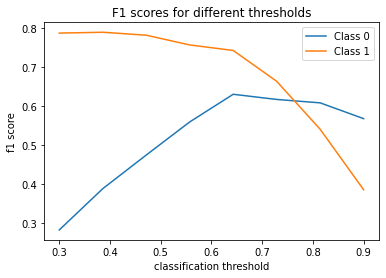

100%|██████████| 3/3 [00:04<00:00,  1.38s/it]

{'Class 0': '0.52', 'Class 1': '0.85'}
  Threshold   Class 0   Class 1
0     0.300  0.282609  0.787097
1     0.386  0.388350  0.789298
2     0.471  0.474576  0.781690
3     0.557  0.559441  0.756757
4     0.643  0.630303  0.742616
5     0.729  0.617021  0.663551
6     0.814  0.608295  0.540541
7     0.900  0.567797  0.385542
  Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[50, 64], [8, 321]]   [[13, 57], [9, 122]]
1     0.386      [[64, 50], [15, 314]]  [[20, 50], [13, 118]]
2     0.471      [[72, 42], [31, 298]]  [[28, 42], [20, 111]]
3     0.557      [[81, 33], [53, 276]]   [[40, 30], [33, 98]]
4     0.643      [[91, 23], [88, 241]]   [[52, 18], [43, 88]]
5     0.729    [[101, 13], [129, 200]]   [[58, 12], [60, 71]]
6     0.814     [[109, 5], [178, 151]]    [[66, 4], [81, 50]]
7     0.900     [[112, 2], [223, 106]]    [[67, 3], [99, 32]]
Average best F1 for class 0:  0.5224479150993551
Average best F1 for class 1:  0.7743082768127799


In [289]:
models_sgd, best_f1_0_list_sgd, best_f1_1_list_sgd = sgd(X_train_list, X_test_list, y_train_list, y_test_list, j=5)

  0%|          | 0/3 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


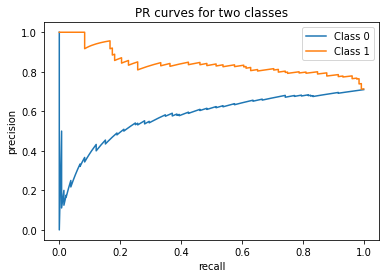

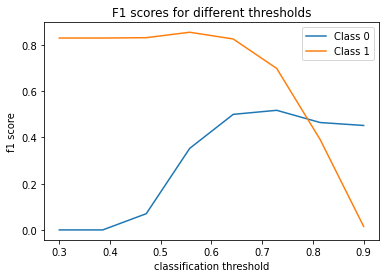

 33%|███▎      | 1/3 [00:25<00:51, 25.79s/it]

{'Class 0': '0.58', 'Class 1': '0.84'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.830189
1     0.386  0.000000  0.830189
2     0.471  0.070175  0.831746
3     0.557  0.352941  0.855263
4     0.643  0.500000  0.826087
5     0.729  0.517483  0.698690
6     0.814  0.464646  0.390805
7     0.900  0.451883  0.015038
  Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[47, 83], [0, 328]]    [[0, 54], [0, 132]]
1     0.386      [[101, 29], [0, 328]]    [[0, 54], [0, 132]]
2     0.471       [[123, 7], [0, 328]]    [[2, 52], [1, 131]]
3     0.557       [[129, 1], [0, 328]]   [[12, 42], [2, 130]]
4     0.643       [[130, 0], [1, 327]]  [[24, 30], [18, 114]]
5     0.729       [[130, 0], [5, 323]]   [[37, 17], [52, 80]]
6     0.814      [[130, 0], [57, 271]]    [[46, 8], [98, 34]]
7     0.900     [[130, 0], [217, 111]]    [[54, 0], [131, 1]]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


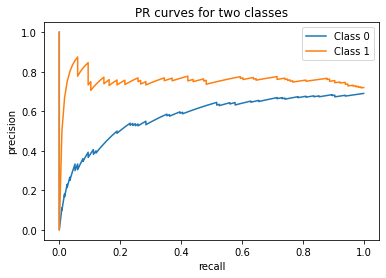

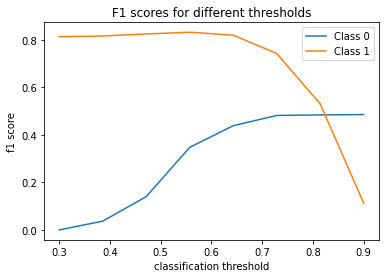

 67%|██████▋   | 2/3 [00:52<00:26, 26.11s/it]

{'Class 0': '0.57', 'Class 1': '0.75'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.814035
1     0.386  0.037037  0.816901
2     0.471  0.140351  0.825623
3     0.557  0.347826  0.832714
4     0.643  0.439024  0.820313
5     0.729  0.482143  0.743363
6     0.814  0.484472  0.531073
7     0.900  0.485981  0.112903
  Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[80, 51], [0, 344]]    [[0, 53], [0, 116]]
1     0.386      [[110, 21], [0, 344]]    [[1, 52], [0, 116]]
2     0.471       [[126, 5], [0, 344]]    [[4, 49], [0, 116]]
3     0.557       [[130, 1], [0, 344]]   [[12, 41], [4, 112]]
4     0.643       [[131, 0], [1, 343]]  [[18, 35], [11, 105]]
5     0.729       [[131, 0], [9, 335]]   [[27, 26], [32, 84]]
6     0.814      [[131, 0], [33, 311]]   [[39, 14], [69, 47]]
7     0.900     [[131, 0], [162, 182]]    [[52, 1], [109, 7]]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


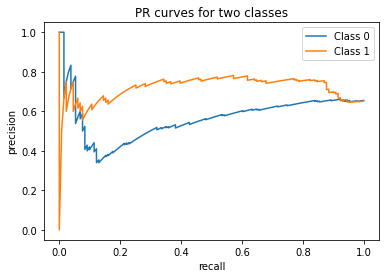

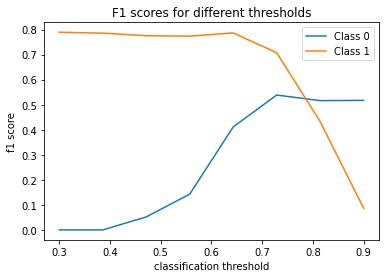

100%|██████████| 3/3 [01:18<00:00, 26.19s/it]

{'Class 0': '0.57', 'Class 1': '0.72'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.789157
1     0.386  0.000000  0.785498
2     0.471  0.051948  0.775385
3     0.557  0.142857  0.773585
4     0.643  0.411215  0.786441
5     0.729  0.538462  0.707317
6     0.814  0.516129  0.432432
7     0.900  0.517110  0.086331
  Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[43, 71], [0, 329]]    [[0, 70], [0, 131]]
1     0.386       [[74, 40], [0, 329]]    [[0, 70], [1, 130]]
2     0.471      [[103, 11], [0, 329]]    [[2, 68], [5, 126]]
3     0.557       [[114, 0], [0, 329]]    [[6, 64], [8, 123]]
4     0.643       [[114, 0], [1, 328]]  [[22, 48], [15, 116]]
5     0.729       [[114, 0], [6, 323]]   [[42, 28], [44, 87]]
6     0.814      [[114, 0], [43, 286]]   [[56, 14], [91, 40]]
7     0.900     [[114, 0], [188, 141]]    [[68, 2], [125, 6]]
Average best F1 for class 0:  0.49249530956848026
Average best F1 for class 1:  0.784572176564157


In [290]:
models_rfc, best_f1_0_list_rfc, best_f1_1_list_rfc = rfc(X_train_list, X_test_list, y_train_list, y_test_list, j=5)

  0%|          | 0/3 [00:00<?, ?it/s]

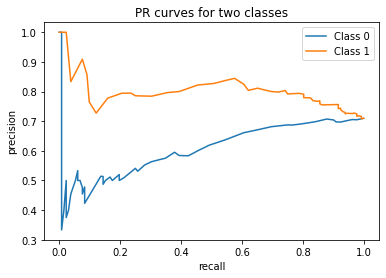

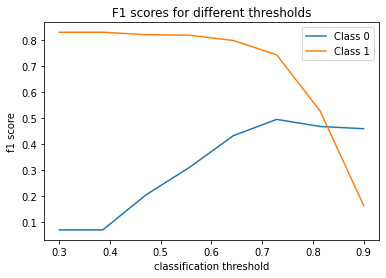

 33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

{'Class 0': '0.61', 'Class 1': '0.80'}
  Threshold   Class 0   Class 1
0     0.300  0.070175  0.831746
1     0.386  0.070175  0.831746
2     0.471  0.205882  0.822368
3     0.557  0.311688  0.820339
4     0.643  0.432990  0.800000
5     0.729  0.496000  0.744939
6     0.814  0.468571  0.527919
7     0.900  0.460177  0.164384
  Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[124, 6], [0, 328]]    [[2, 52], [1, 131]]
1     0.386       [[130, 0], [0, 328]]    [[2, 52], [1, 131]]
2     0.471       [[130, 0], [0, 328]]    [[7, 47], [7, 125]]
3     0.557       [[130, 0], [0, 328]]  [[12, 42], [11, 121]]
4     0.643       [[130, 0], [0, 328]]  [[21, 33], [22, 110]]
5     0.729       [[130, 0], [1, 327]]   [[31, 23], [40, 92]]
6     0.814       [[130, 0], [6, 322]]   [[41, 13], [80, 52]]
7     0.900      [[130, 0], [85, 243]]   [[52, 2], [120, 12]]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


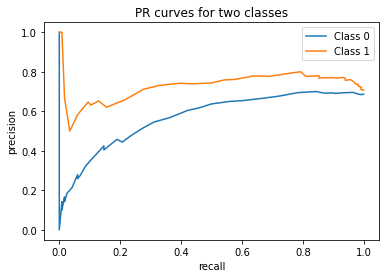

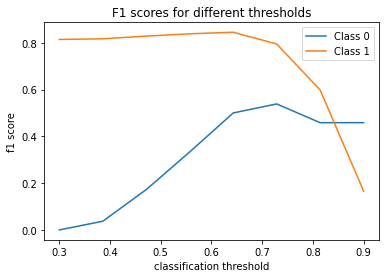

 67%|██████▋   | 2/3 [00:03<00:01,  1.61s/it]

{'Class 0': '0.57', 'Class 1': '0.73'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.814035
1     0.386  0.037037  0.816901
2     0.471  0.172414  0.828571
3     0.557  0.333333  0.838235
4     0.643  0.500000  0.844961
5     0.729  0.538462  0.794872
6     0.814  0.458333  0.597938
7     0.900  0.458537  0.165414
  Threshold Confusion matrix for train      Confusion matrix
0     0.300      [[120, 11], [0, 344]]   [[0, 53], [0, 116]]
1     0.386       [[131, 0], [0, 344]]   [[1, 52], [0, 116]]
2     0.471       [[131, 0], [0, 344]]   [[5, 48], [0, 116]]
3     0.557       [[131, 0], [0, 344]]  [[11, 42], [2, 114]]
4     0.643       [[131, 0], [0, 344]]  [[20, 33], [7, 109]]
5     0.729       [[131, 0], [4, 340]]  [[28, 25], [23, 93]]
6     0.814      [[131, 0], [12, 332]]  [[33, 20], [58, 58]]
7     0.900      [[131, 0], [85, 259]]  [[47, 6], [105, 11]]


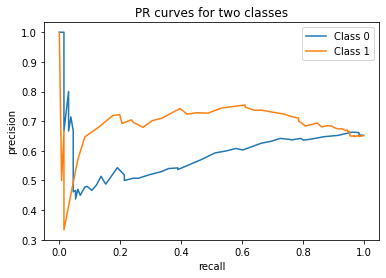

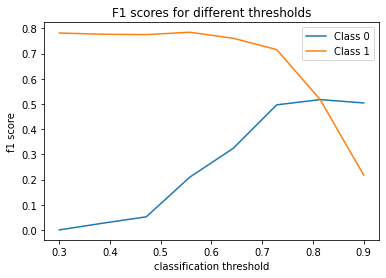

100%|██████████| 3/3 [00:04<00:00,  1.63s/it]

{'Class 0': '0.59', 'Class 1': '0.69'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.781818
1     0.386  0.026667  0.776758
2     0.471  0.051948  0.775385
3     0.557  0.209302  0.784810
4     0.643  0.323810  0.760943
5     0.729  0.496552  0.715953
6     0.814  0.517413  0.517413
7     0.900  0.504065  0.217949
  Threshold Confusion matrix for train       Confusion matrix
0     0.300      [[100, 14], [0, 329]]    [[0, 70], [2, 129]]
1     0.386       [[114, 0], [0, 329]]    [[1, 69], [4, 127]]
2     0.471       [[114, 0], [0, 329]]    [[2, 68], [5, 126]]
3     0.557       [[114, 0], [0, 329]]    [[9, 61], [7, 124]]
4     0.643       [[114, 0], [0, 329]]  [[17, 53], [18, 113]]
5     0.729       [[114, 0], [1, 328]]   [[36, 34], [39, 92]]
6     0.814       [[114, 0], [6, 323]]   [[52, 18], [79, 52]]
7     0.900      [[114, 0], [73, 256]]   [[62, 8], [114, 17]]
Average best F1 for class 0:  0.5103377541998232
Average best F1 for class 1:  0.7519214578399507


In [366]:
models_rfc2, best_f1_0_list_rfc2, best_f1_1_list_rfc2 = rfc2(X_train_list, X_test_list, y_train_list, y_test_list, j=5)

  0%|          | 0/3 [00:00<?, ?it/s]

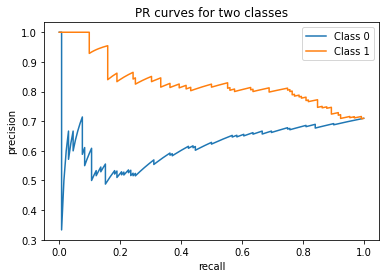

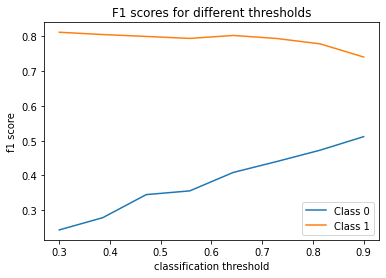

 33%|███▎      | 1/3 [01:32<03:05, 92.91s/it]

Precision recall AUC {'Class 0': '0.62', 'Class 1': '0.83'}
F1   Threshold   Class 0   Class 1
0     0.300  0.243243  0.812081
1     0.386  0.278481  0.805461
2     0.471  0.344828  0.800000
3     0.557  0.355556  0.794326
4     0.643  0.408602  0.802867
5     0.729  0.440000  0.794118
6     0.814  0.472727  0.778626
7     0.900  0.511628  0.740741
Confusion matrix   Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[130, 0], [0, 328]]   [[9, 45], [11, 121]]
1     0.386       [[130, 0], [0, 328]]  [[11, 43], [14, 118]]
2     0.471       [[130, 0], [0, 328]]  [[15, 39], [18, 114]]
3     0.557       [[130, 0], [0, 328]]  [[16, 38], [20, 112]]
4     0.643       [[130, 0], [0, 328]]  [[19, 35], [20, 112]]
5     0.729       [[130, 0], [0, 328]]  [[22, 32], [24, 108]]
6     0.814       [[130, 0], [0, 328]]  [[26, 28], [30, 102]]
7     0.900       [[130, 0], [0, 328]]   [[33, 21], [42, 90]]


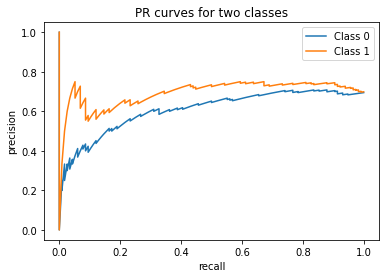

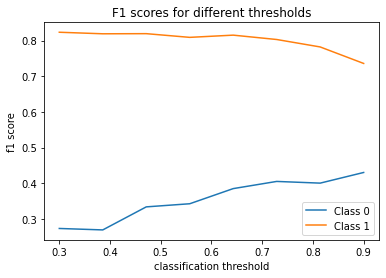

 67%|██████▋   | 2/3 [02:35<01:14, 74.90s/it]

Precision recall AUC {'Class 0': '0.61', 'Class 1': '0.69'}
F1   Threshold   Class 0   Class 1
0     0.300  0.272727  0.823529
1     0.386  0.268657  0.819188
2     0.471  0.333333  0.819549
3     0.557  0.342105  0.809160
4     0.643  0.384615  0.815385
5     0.729  0.404762  0.803150
6     0.814  0.400000  0.782258
7     0.900  0.429907  0.735931
Confusion matrix   Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[131, 0], [0, 344]]    [[9, 44], [4, 112]]
1     0.386       [[131, 0], [0, 344]]    [[9, 44], [5, 111]]
2     0.471       [[131, 0], [0, 344]]   [[12, 41], [7, 109]]
3     0.557       [[131, 0], [0, 344]]  [[13, 40], [10, 106]]
4     0.643       [[131, 0], [0, 344]]  [[15, 38], [10, 106]]
5     0.729       [[131, 0], [0, 344]]  [[17, 36], [14, 102]]
6     0.814       [[131, 0], [0, 344]]   [[18, 35], [19, 97]]
7     0.900       [[131, 0], [0, 344]]   [[23, 30], [31, 85]]


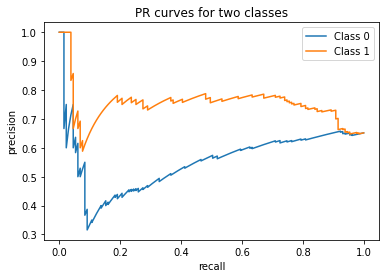

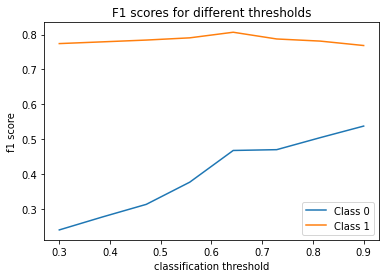

100%|██████████| 3/3 [03:38<00:00, 72.71s/it]

Precision recall AUC {'Class 0': '0.56', 'Class 1': '0.75'}
F1   Threshold   Class 0   Class 1
0     0.300  0.239130  0.774194
1     0.386  0.276596  0.779221
2     0.471  0.312500  0.784314
3     0.557  0.376238  0.790698
4     0.643  0.467290  0.806780
5     0.729  0.469565  0.787456
6     0.814  0.504065  0.781362
7     0.900  0.537313  0.768657
Confusion matrix   Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[114, 0], [0, 329]]  [[11, 59], [11, 120]]
1     0.386       [[114, 0], [0, 329]]  [[13, 57], [11, 120]]
2     0.471       [[114, 0], [0, 329]]  [[15, 55], [11, 120]]
3     0.557       [[114, 0], [0, 329]]  [[19, 51], [12, 119]]
4     0.643       [[114, 0], [0, 329]]  [[25, 45], [12, 119]]
5     0.729       [[114, 0], [0, 329]]  [[27, 43], [18, 113]]
6     0.814       [[114, 0], [0, 329]]  [[31, 39], [22, 109]]
7     0.900       [[114, 0], [0, 329]]  [[36, 34], [28, 103]]
Average best F1 for class 0:  0.4845677481914899
Average best F1 for class

In [358]:
models_xgb, best_f1_0_list_xgb, best_f1_1_list_xgb = xgboost(X_train_list, X_test_list, y_train_list, y_test_list, j=5)

  0%|          | 0/3 [00:00<?, ?it/s]

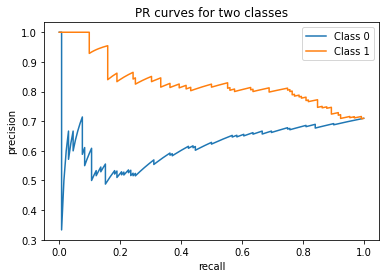

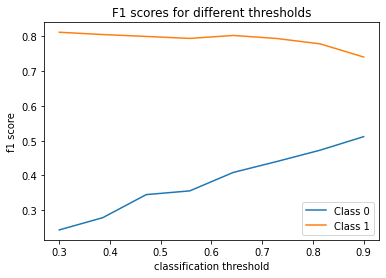

 33%|███▎      | 1/3 [00:02<00:05,  2.74s/it]

Precision recall AUC {'Class 0': '0.62', 'Class 1': '0.83'}
F1   Threshold   Class 0   Class 1
0     0.300  0.243243  0.812081
1     0.386  0.278481  0.805461
2     0.471  0.344828  0.800000
3     0.557  0.355556  0.794326
4     0.643  0.408602  0.802867
5     0.729  0.440000  0.794118
6     0.814  0.472727  0.778626
7     0.900  0.511628  0.740741
Confusion matrix   Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[130, 0], [0, 328]]   [[9, 45], [11, 121]]
1     0.386       [[130, 0], [0, 328]]  [[11, 43], [14, 118]]
2     0.471       [[130, 0], [0, 328]]  [[15, 39], [18, 114]]
3     0.557       [[130, 0], [0, 328]]  [[16, 38], [20, 112]]
4     0.643       [[130, 0], [0, 328]]  [[19, 35], [20, 112]]
5     0.729       [[130, 0], [0, 328]]  [[22, 32], [24, 108]]
6     0.814       [[130, 0], [0, 328]]  [[26, 28], [30, 102]]
7     0.900       [[130, 0], [0, 328]]   [[33, 21], [42, 90]]


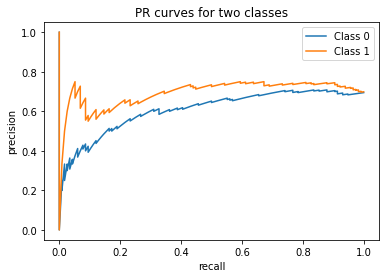

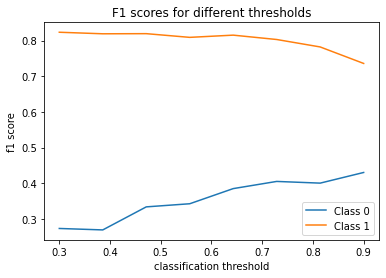

 67%|██████▋   | 2/3 [00:05<00:03,  3.02s/it]

Precision recall AUC {'Class 0': '0.61', 'Class 1': '0.69'}
F1   Threshold   Class 0   Class 1
0     0.300  0.272727  0.823529
1     0.386  0.268657  0.819188
2     0.471  0.333333  0.819549
3     0.557  0.342105  0.809160
4     0.643  0.384615  0.815385
5     0.729  0.404762  0.803150
6     0.814  0.400000  0.782258
7     0.900  0.429907  0.735931
Confusion matrix   Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[131, 0], [0, 344]]    [[9, 44], [4, 112]]
1     0.386       [[131, 0], [0, 344]]    [[9, 44], [5, 111]]
2     0.471       [[131, 0], [0, 344]]   [[12, 41], [7, 109]]
3     0.557       [[131, 0], [0, 344]]  [[13, 40], [10, 106]]
4     0.643       [[131, 0], [0, 344]]  [[15, 38], [10, 106]]
5     0.729       [[131, 0], [0, 344]]  [[17, 36], [14, 102]]
6     0.814       [[131, 0], [0, 344]]   [[18, 35], [19, 97]]
7     0.900       [[131, 0], [0, 344]]   [[23, 30], [31, 85]]


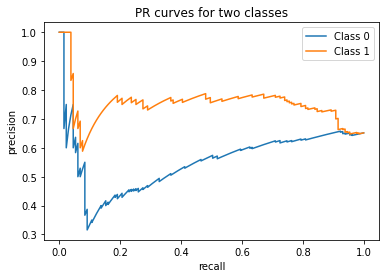

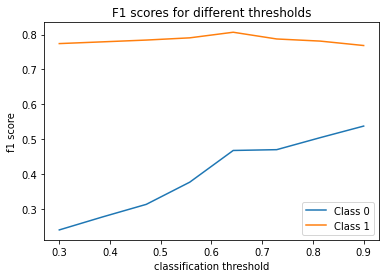

100%|██████████| 3/3 [00:08<00:00,  2.90s/it]

Precision recall AUC {'Class 0': '0.56', 'Class 1': '0.75'}
F1   Threshold   Class 0   Class 1
0     0.300  0.239130  0.774194
1     0.386  0.276596  0.779221
2     0.471  0.312500  0.784314
3     0.557  0.376238  0.790698
4     0.643  0.467290  0.806780
5     0.729  0.469565  0.787456
6     0.814  0.504065  0.781362
7     0.900  0.537313  0.768657
Confusion matrix   Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[114, 0], [0, 329]]  [[11, 59], [11, 120]]
1     0.386       [[114, 0], [0, 329]]  [[13, 57], [11, 120]]
2     0.471       [[114, 0], [0, 329]]  [[15, 55], [11, 120]]
3     0.557       [[114, 0], [0, 329]]  [[19, 51], [12, 119]]
4     0.643       [[114, 0], [0, 329]]  [[25, 45], [12, 119]]
5     0.729       [[114, 0], [0, 329]]  [[27, 43], [18, 113]]
6     0.814       [[114, 0], [0, 329]]  [[31, 39], [22, 109]]
7     0.900       [[114, 0], [0, 329]]  [[36, 34], [28, 103]]
Average best F1 for class 0:  0.4845677481914899
Average best F1 for class

In [365]:
models_xgb2, best_f1_0_list_xgb2, best_f1_1_list_xgb2 = xgboost2(X_train_list, X_test_list, y_train_list, y_test_list, j=5)


## Model interpretation

### Mutual information

In [387]:
mutual_info_feat_list = []
for i in tqdm(range(len(X_train_list))):
    mutual_info_feat = []
    for k in range(10, 200, 10):
        mutual_info_feat.append(mutual_info(X_train_list[i].drop(columns=['Participant ID']), np.array(y_train_list[i].drop(columns=['Participant ID'])).ravel(), k))
    mutual_info_feat_list.append(mutual_info_feat)

100%|██████████| 3/3 [03:39<00:00, 73.04s/it]


In [412]:
for i in range(len(X_train_list)):
    print(list(mutual_info_feat_list[i][1]))

['ARO-PWY chorismate biosynthesis I', 'CALVIN-PWY Calvin-Benson-Bassham cycle', 'PANTOSYN-PWY pantothenate and coenzyme A biosynthesis I', 'PWY-3781 aerobic respiration I (cytochrome c)', 'PWY-5173 superpathway of acetyl-CoA biosynthesis', 'PWY-5177 glutaryl-CoA degradation', 'PWY-5791 14-dihydroxy-2-naphthoate biosynthesis II (plants)', 'PWY-6126 superpathway of adenosine nucleotides de novo biosynthesis II', 'PWY-6147 6-hydroxymethyl-dihydropterin diphosphate biosynthesis I', 'PWY-6387 UDP-N-acetylmuramoyl-pentapeptide biosynthesis I (meso-diaminopimelate containing)', 'PWY-6545 pyrimidine deoxyribonucleotides de novo biosynthesis III', 'PWY-7220 adenosine deoxyribonucleotides de novo biosynthesis II', 'PWY-7222 guanosine deoxyribonucleotides de novo biosynthesis II', 'PWY-7229 superpathway of adenosine nucleotides de novo biosynthesis I', "PWY-7234 inosine-5'-phosphate biosynthesis III", 'PWY-7279 aerobic respiration II (cytochrome c) (yeast)', 'PWY-7288 fatty acid &beta;-oxidation 

In [414]:
mutual_info_feat_list_for_overlap = []
for i in range(len(X_train_list)):
    mutual_info_feat_list_for_overlap.append(list(mutual_info_feat_list[i][3]))

### SGD coefficients

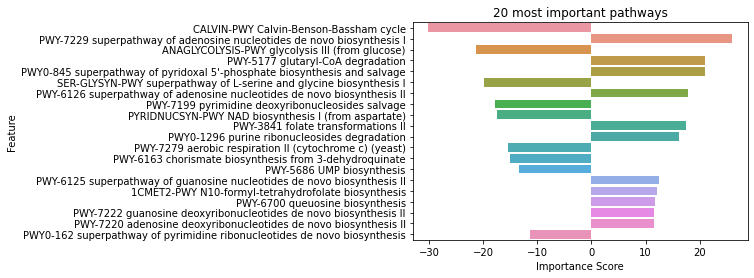

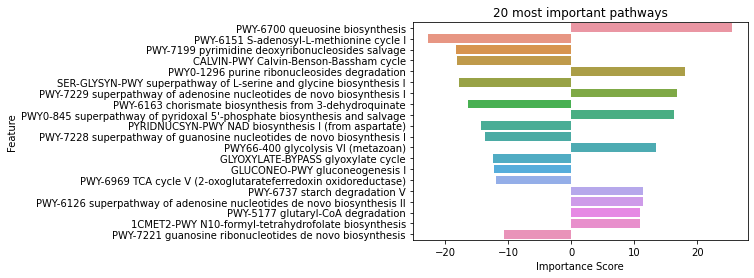

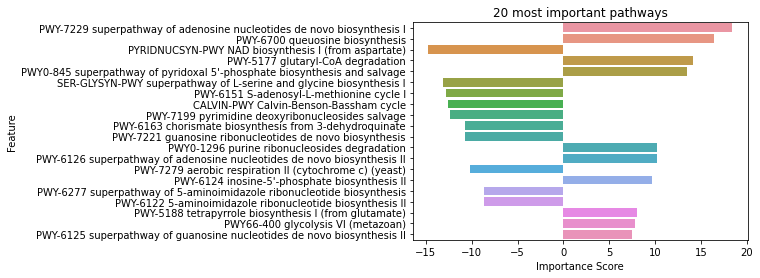

In [415]:
common_sgd_feats = []
for i in range(len(X_train_list)):
    f = linear_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_sgd[i], j=20)
    common_sgd_feats.append(bestklinear(f, 20))

### SVC coefficients

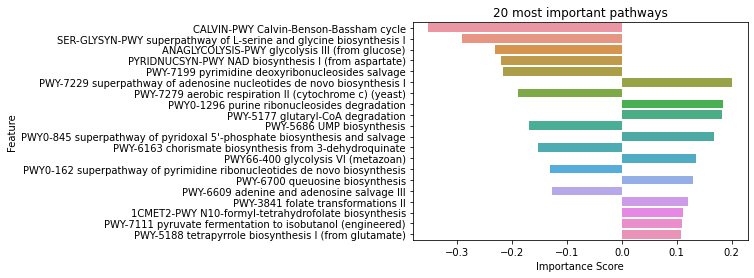

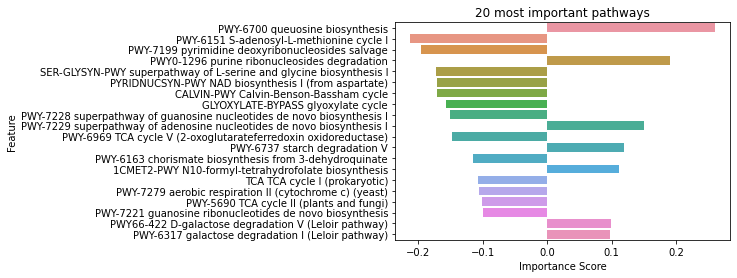

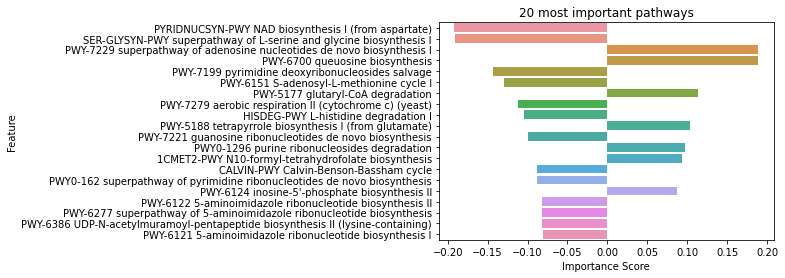

In [416]:
common_svc_feats = []
for i in range(len(X_train_list)):
    f = linear_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_svc[i], j=20)
    common_svc_feats.append(bestklinear(f, 20))

### Gini importance (random forest classifier)

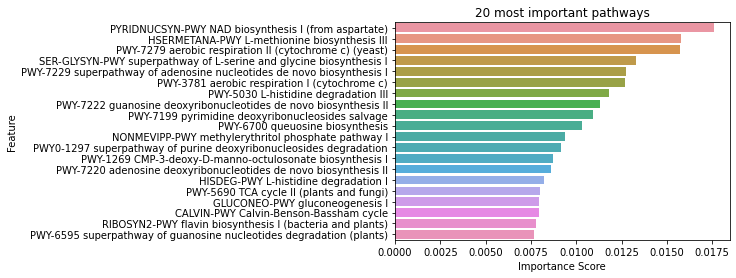

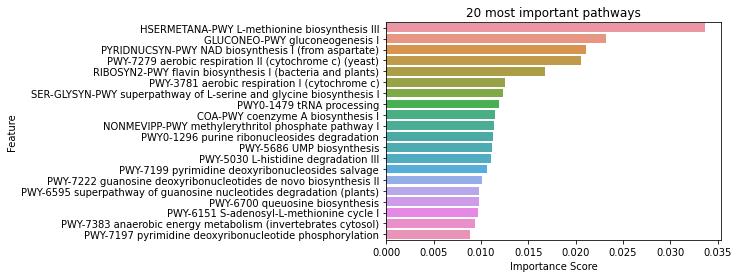

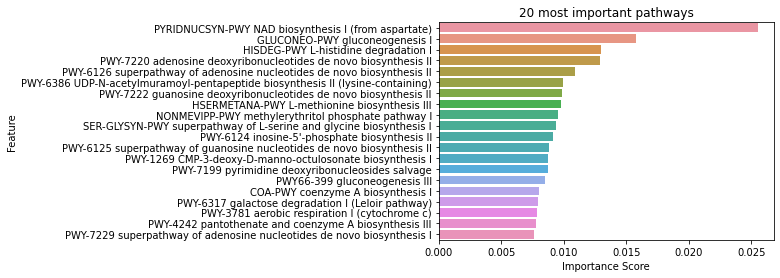

In [417]:
common_rf_feats = []
for i in range(len(X_train_list)):
    f = tree_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_rfc[i], k=20)
    common_rf_feats.append(bestktree(f, 20))

### SHAP importance (random forest classifier)

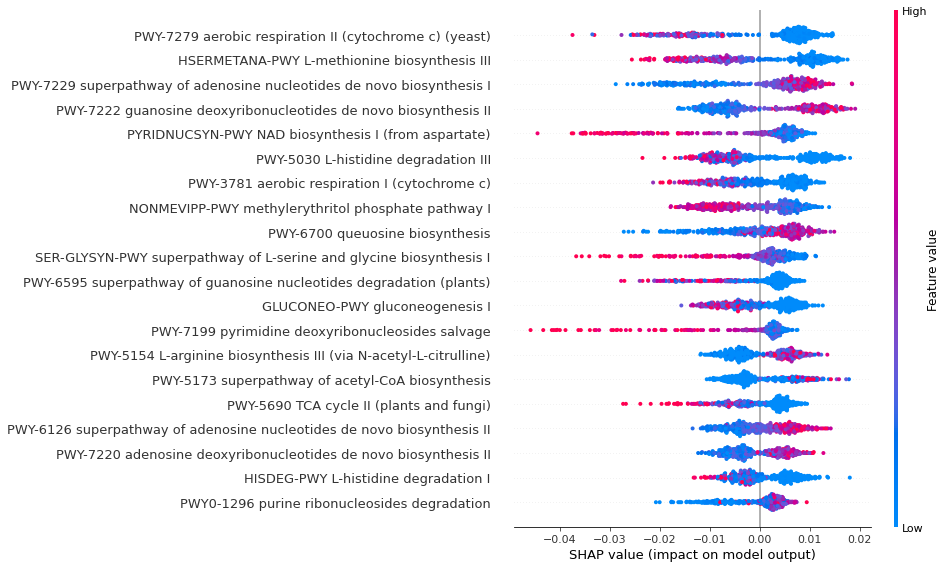

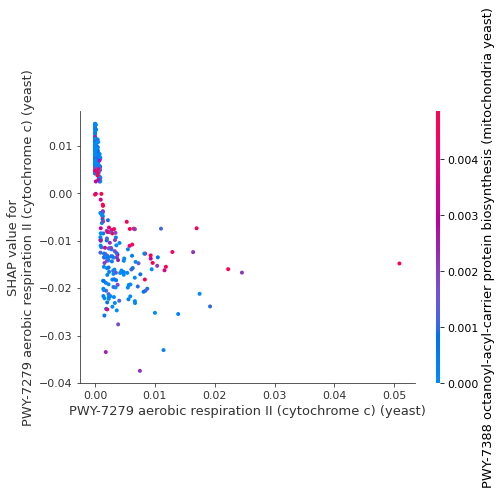

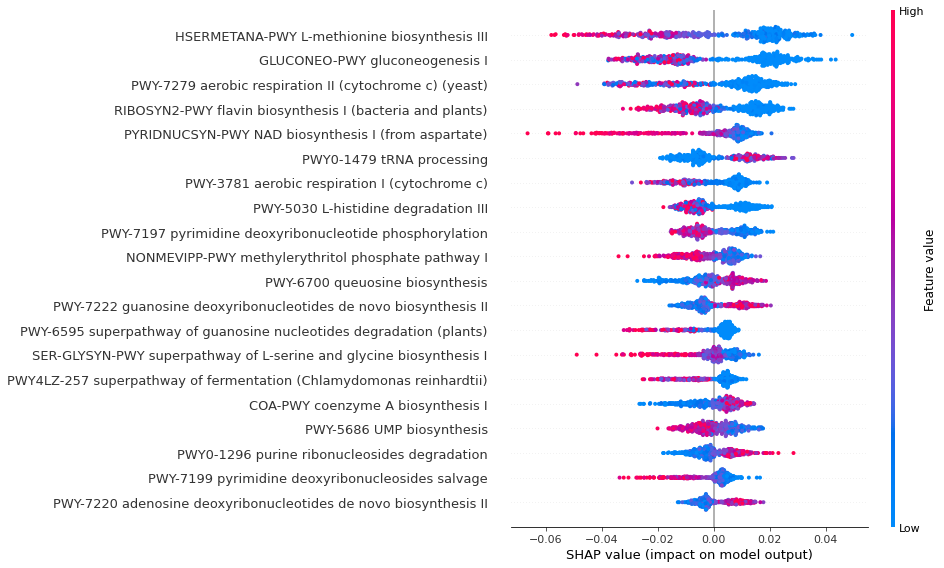

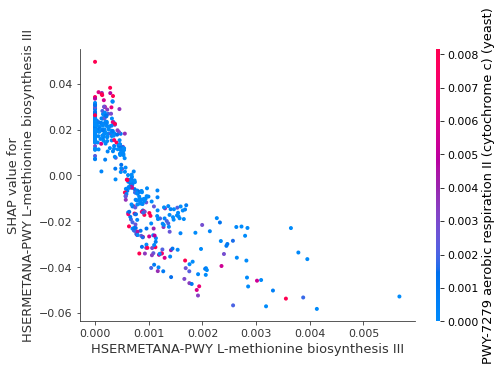

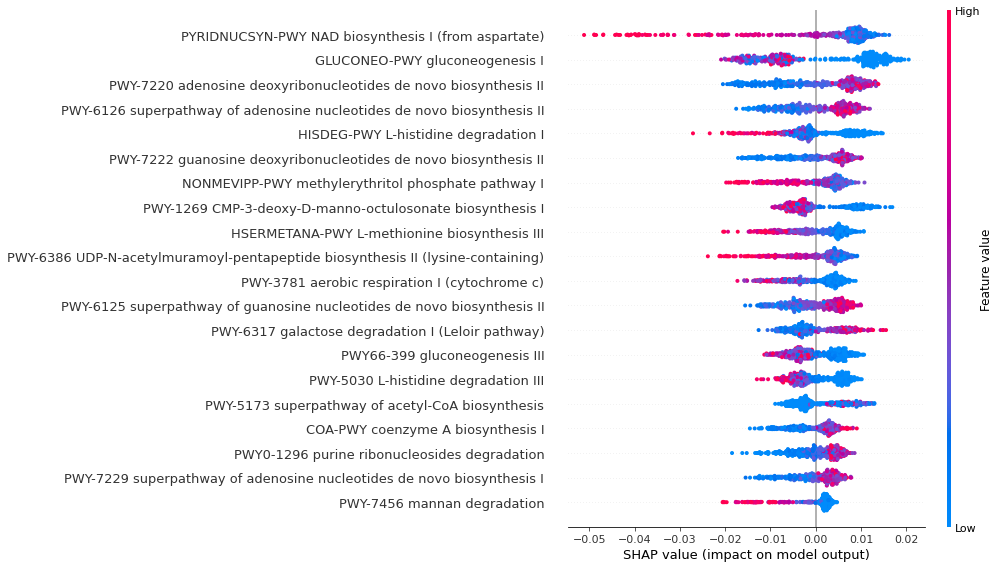

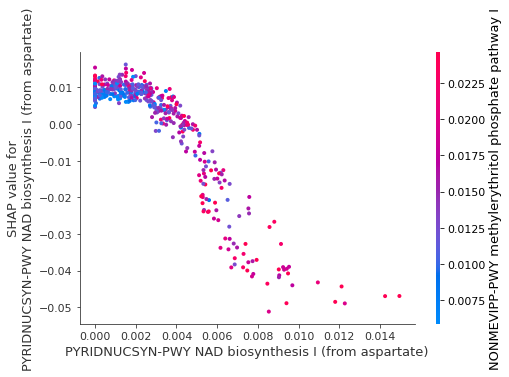

In [418]:
common_rfshap_feats = []
for i in range(len(X_train_list)):
    one_sample_rfc, x = shap_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_rfc[i], j=3)
    common_rfshap_feats.append(bestkshap(X_train_list[i].drop(columns=['Participant ID']), x, 20))

In [298]:
one_sample_rfc

### Default importance (gradient boosting)

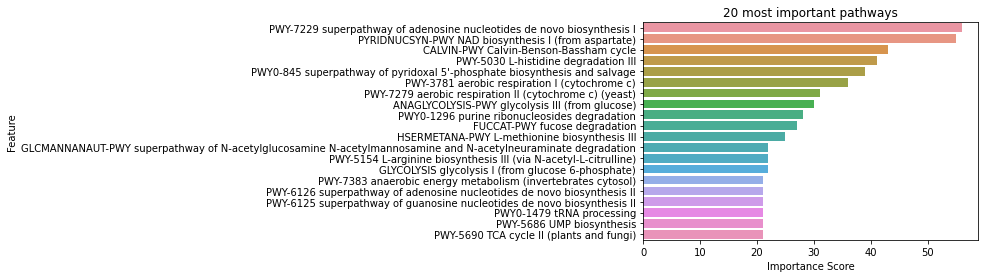

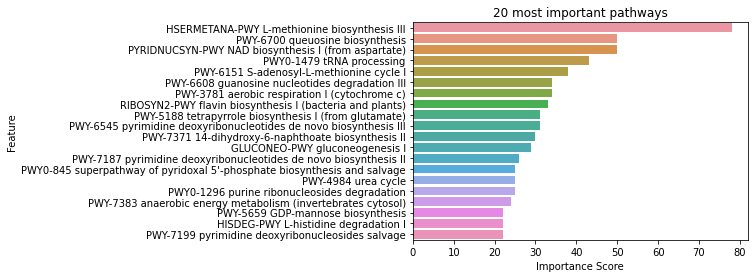

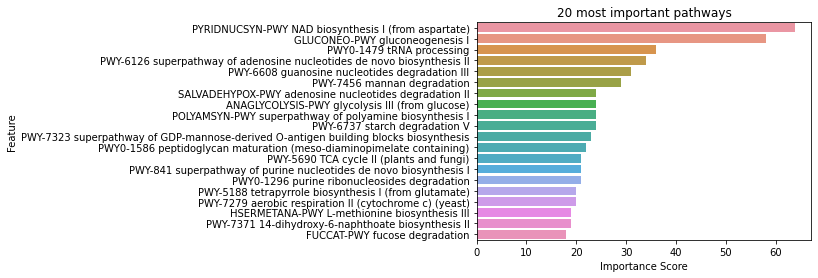

In [419]:
common_xgb_feats = []
for i in range(len(X_train_list)):
    f = tree_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_xgb[i], k=20)
    common_xgb_feats.append(bestktree(f, 20))

### SHAP importance (gradient boosting)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


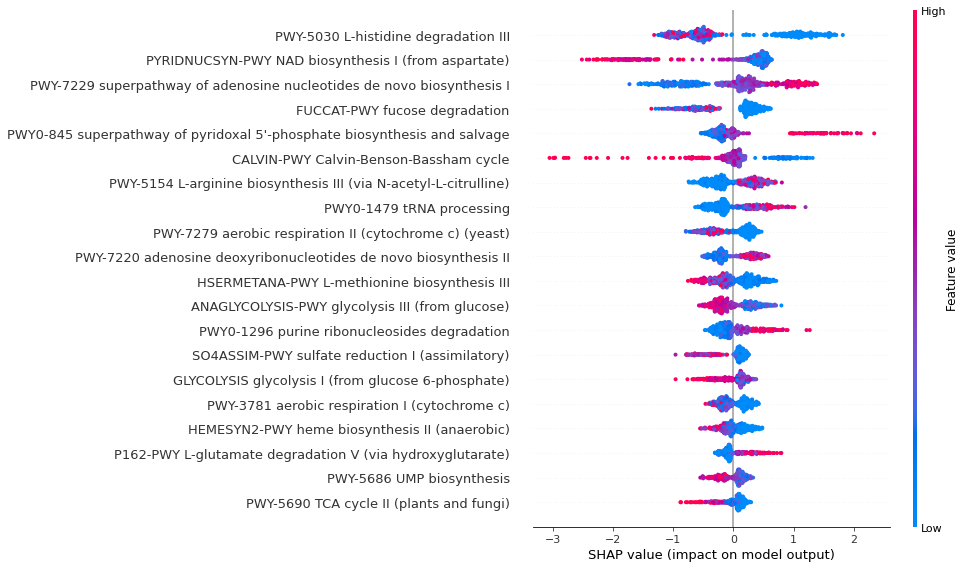

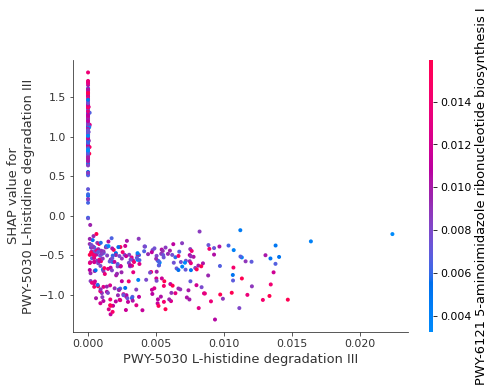

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


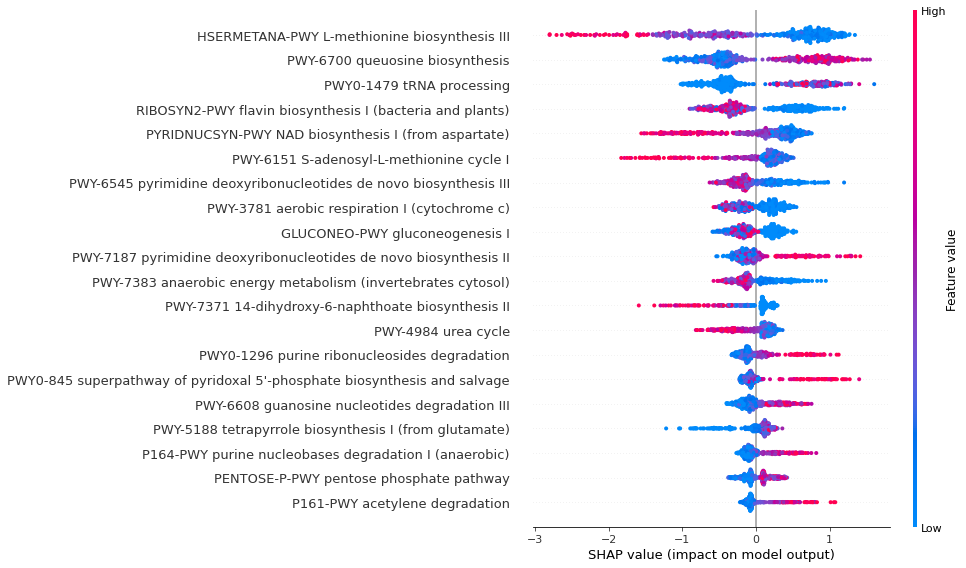

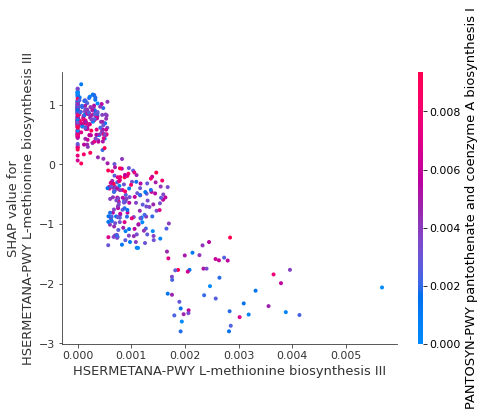

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


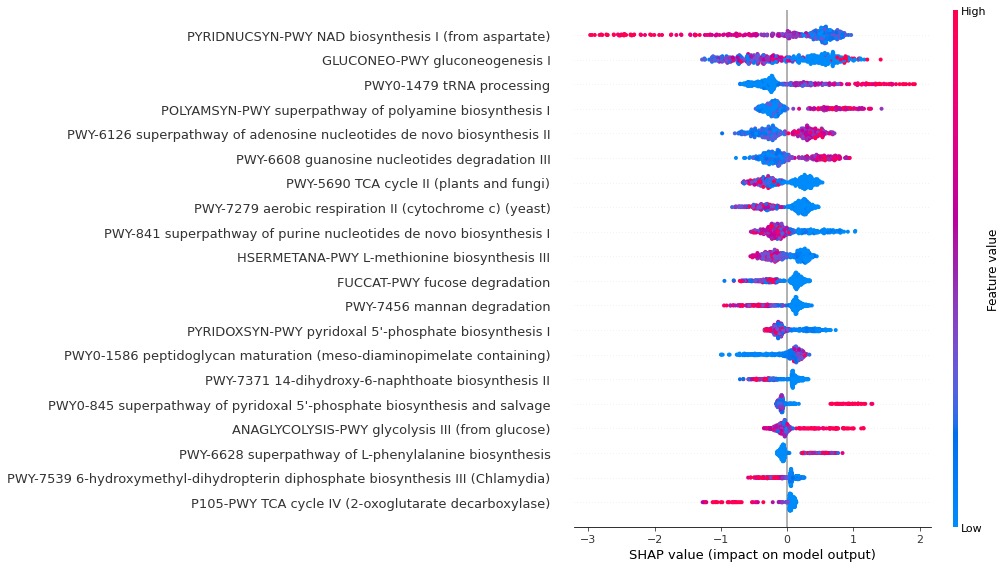

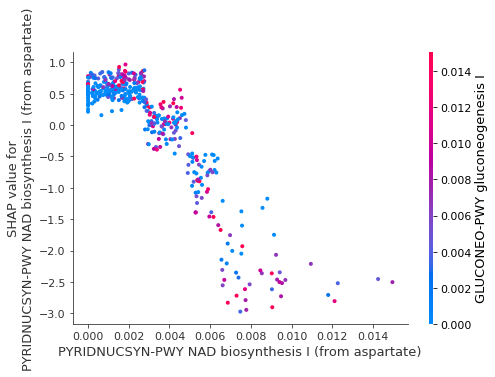

In [420]:
common_xgbshap_feats = []
for i in range(len(X_train_list)):
    one_sample_xgb, s = shap_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_xgb[i], j=3)
    common_xgbshap_feats.append(bestkshap(X_train_list[i].drop(columns=['Participant ID']), s, 20))

In [301]:
one_sample_xgb

In [421]:
common_features_all = []
for each in [mutual_info_feat_list_for_overlap, common_svc_feats, common_sgd_feats, common_rf_feats,\
            common_rfshap_feats, common_xgb_feats, common_xgbshap_feats]:
    common_features_all.append(find_overlap(each)[1])

find_overlap(common_features_all)

({'PWY-3781 aerobic respiration I (cytochrome c)': 2,
  'PWY-7279 aerobic respiration II (cytochrome c) (yeast)': 2,
  'PWY-6163 chorismate biosynthesis from 3-dehydroquinate': 1,
  "PWY0-845 superpathway of pyridoxal 5'-phosphate biosynthesis and salvage": 2,
  'PWY-6700 queuosine biosynthesis': 2,
  'PYRIDNUCSYN-PWY NAD biosynthesis I (from aspartate)': 7,
  'NONMEVIPP-PWY methylerythritol phosphate pathway I': 2,
  'HSERMETANA-PWY L-methionine biosynthesis III': 5,
  'PWY-7229 superpathway of adenosine nucleotides de novo biosynthesis I': 2,
  'CALVIN-PWY Calvin-Benson-Bassham cycle': 2,
  'PWY-7222 guanosine deoxyribonucleotides de novo biosynthesis II': 2,
  'PWY0-1479 tRNA processing': 2,
  'PWY-6126 superpathway of adenosine nucleotides de novo biosynthesis II': 1,
  'PWY-5030 L-histidine degradation III': 1,
  'PWY-5177 glutaryl-CoA degradation': 1,
  'PWY0-1296 purine ribonucleosides degradation': 4,
  'PWY-7220 adenosine deoxyribonucleotides de novo biosynthesis II': 1,
  'PW

## Model performance with selected features

### Train test split

In [302]:
X_train_temp = []
X_test_temp = []
y_train_temp = []
y_test_temp  = []

for i in range(1):
    X_train_, X_test_, y_train_, y_test_, _, _ = patient_split(X_all, y_all)
    X_train_temp.append(X_train_)
    X_test_temp.append(X_test_)
    y_train_temp.append(y_train_)
    y_test_temp.append(y_test_)

In [410]:
print('# IBD people', X_train_temp[0][y_train_temp[0]['diseased']==1].groupby('Participant ID').sum().shape[0])
print('# healthy people', X_train_temp[0][y_train_temp[0]['diseased']==0].groupby('Participant ID').sum().shape[0])
print('# IBD samples', y_train_temp[0][y_train_temp[0]['diseased']==1].shape[0])
print('# healthy samples', y_train_temp[0][y_train_temp[0]['diseased']==0].shape[0])

# IBD people 43
# healthy people 18
# IBD samples 362
# healthy samples 135


In [411]:
print('# IBD people', X_test_temp[0][y_test_temp[0]['diseased']==1].groupby('Participant ID').sum().shape[0])
print('# healthy people', X_test_temp[0][y_test_temp[0]['diseased']==0].groupby('Participant ID').sum().shape[0])
print('# IBD samples', y_test_temp[0][y_test_temp[0]['diseased']==1].shape[0])
print('# healthy samples', y_test_temp[0][y_test_temp[0]['diseased']==0].shape[0])

# IBD people 12
# healthy people 8
# IBD samples 98
# healthy samples 49


### Random forest classifier

  0%|          | 0/1 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


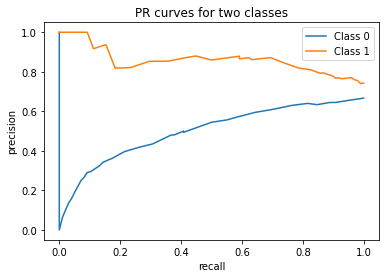

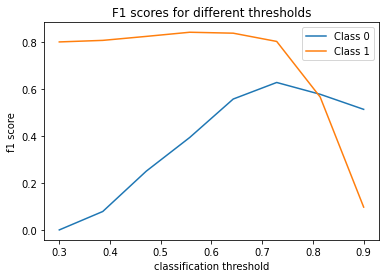

100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

{'Class 0': '0.50', 'Class 1': '0.86'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.800000
1     0.386  0.078431  0.806584
2     0.471  0.250000  0.823529
3     0.557  0.393443  0.841202
4     0.643  0.556962  0.837209
5     0.729  0.627451  0.802083
6     0.814  0.577181  0.565517
7     0.900  0.513089  0.097087
  Threshold Confusion matrix for train      Confusion matrix
0     0.300      [[120, 15], [0, 362]]    [[0, 49], [0, 98]]
1     0.386       [[135, 0], [0, 362]]    [[2, 47], [0, 98]]
2     0.471       [[135, 0], [0, 362]]    [[7, 42], [0, 98]]
3     0.557       [[135, 0], [0, 362]]   [[12, 37], [0, 98]]
4     0.643       [[135, 0], [0, 362]]   [[22, 27], [8, 90]]
5     0.729       [[135, 0], [0, 362]]  [[32, 17], [21, 77]]
6     0.814       [[135, 0], [9, 353]]   [[43, 6], [57, 41]]
7     0.900     [[135, 0], [101, 261]]    [[49, 0], [93, 5]]
Average best F1 for class 0:  0.6274509803921567
Average best F1 for class 1:  0.8020833333333333


In [369]:
model_rf, f1_0_rf, f1_1_rf = rfc2(X_train_temp, X_test_temp, y_train_temp, y_test_temp, j=5)
model_rf = model_rf[0]
f1_0_rf = f1_0_rf[0]
f1_1_rf = f1_1_rf[0]

### Gradient boosting classifier

  0%|          | 0/1 [00:00<?, ?it/s]

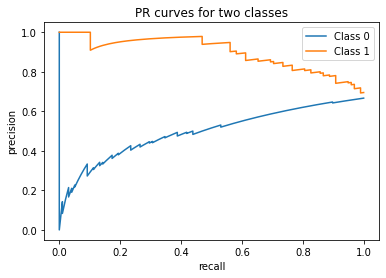

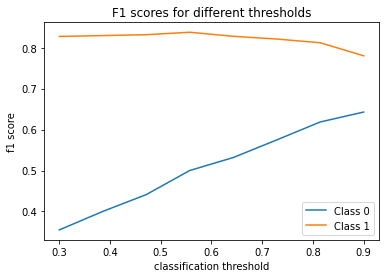

100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

Precision recall AUC {'Class 0': '0.49', 'Class 1': '0.90'}
F1   Threshold   Class 0   Class 1
0     0.300  0.354839  0.827586
1     0.386  0.400000  0.829694
2     0.471  0.441176  0.831858
3     0.557  0.500000  0.837838
4     0.643  0.531646  0.827907
5     0.729  0.574713  0.821256
6     0.814  0.618557  0.812183
7     0.900  0.642857  0.780220
Confusion matrix   Threshold Confusion matrix for train      Confusion matrix
0     0.300       [[135, 0], [0, 362]]   [[11, 38], [2, 96]]
1     0.386       [[135, 0], [0, 362]]   [[13, 36], [3, 95]]
2     0.471       [[135, 0], [0, 362]]   [[15, 34], [4, 94]]
3     0.557       [[135, 0], [0, 362]]   [[18, 31], [5, 93]]
4     0.643       [[135, 0], [0, 362]]   [[21, 28], [9, 89]]
5     0.729       [[135, 0], [0, 362]]  [[25, 24], [13, 85]]
6     0.814       [[135, 0], [0, 362]]  [[30, 19], [18, 80]]
7     0.900       [[135, 0], [0, 362]]  [[36, 13], [27, 71]]
Average best F1 for class 0:  0.6185567010309279
Average best F1 for class 1:  0.81

In [370]:
model_xgb, f1_0_xgb, f1_1_xgb = xgboost2(X_train_temp, X_test_temp, y_train_temp, y_test_temp, j=5)
model_xgb = model_xgb[0]
f1_0_xgb = f1_0_xgb[0]
f1_1_xgb = f1_1_xgb[0]

### Support vector classifier

  0%|          | 0/1 [00:00<?, ?it/s]

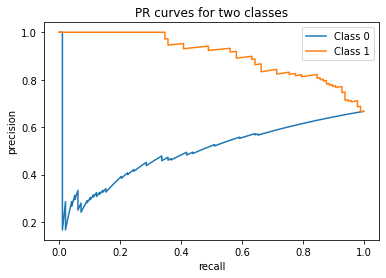

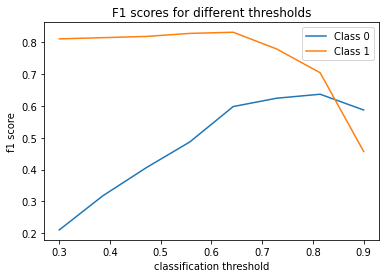

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

{'Class 0': '0.51', 'Class 1': '0.91'}
  Threshold   Class 0   Class 1
0     0.300  0.210526  0.810127
1     0.386  0.317460  0.813853
2     0.471  0.405797  0.817778
3     0.557  0.486486  0.827273
4     0.643  0.597701  0.830918
5     0.729  0.623853  0.778378
6     0.814  0.636364  0.703704
7     0.900  0.586826  0.456693
  Threshold Confusion matrix for train      Confusion matrix
0     0.300       [[46, 89], [4, 358]]    [[6, 43], [2, 96]]
1     0.386       [[63, 72], [7, 355]]   [[10, 39], [4, 94]]
2     0.471      [[69, 66], [13, 349]]   [[14, 35], [6, 92]]
3     0.557      [[81, 54], [21, 341]]   [[18, 31], [7, 91]]
4     0.643      [[97, 38], [32, 330]]  [[26, 23], [12, 86]]
5     0.729     [[111, 24], [64, 298]]  [[34, 15], [26, 72]]
6     0.814    [[121, 14], [120, 242]]   [[42, 7], [41, 57]]
7     0.900     [[134, 1], [258, 104]]   [[49, 0], [69, 29]]
Average best F1 for class 0:  0.5977011494252874
Average best F1 for class 1:  0.8309178743961353


In [305]:
model_svc, f1_0_svc, f1_1_svc = svc(X_train_temp, X_test_temp, y_train_temp, y_test_temp, j=5)
model_svc = model_svc[0]
f1_0_svc = f1_0_svc[0]
f1_1_svc = f1_1_svc[0]

### Stochastic gradient descent classifier

  0%|          | 0/1 [00:00<?, ?it/s]

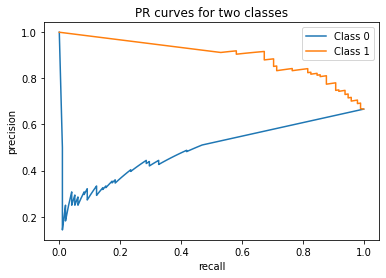

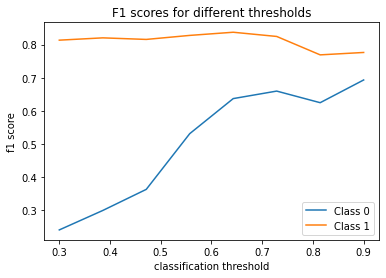

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

{'Class 0': '0.50', 'Class 1': '0.90'}
  Threshold   Class 0   Class 1
0     0.300  0.241379  0.813559
1     0.386  0.300000  0.820513
2     0.471  0.363636  0.815789
3     0.557  0.531646  0.827907
4     0.643  0.637363  0.837438
5     0.729  0.660000  0.824742
6     0.814  0.625000  0.769231
7     0.900  0.693548  0.776471
  Threshold Confusion matrix for train      Confusion matrix
0     0.300       [[43, 92], [3, 359]]    [[7, 42], [2, 96]]
1     0.386       [[51, 84], [6, 356]]    [[9, 40], [2, 96]]
2     0.471      [[66, 69], [11, 351]]   [[12, 37], [5, 93]]
3     0.557      [[77, 58], [23, 339]]   [[21, 28], [9, 89]]
4     0.643      [[89, 46], [42, 320]]  [[29, 20], [13, 85]]
5     0.729     [[101, 34], [60, 302]]  [[33, 16], [18, 80]]
6     0.814     [[111, 24], [88, 274]]  [[35, 14], [28, 70]]
7     0.900    [[121, 14], [132, 230]]   [[43, 6], [32, 66]]
Average best F1 for class 0:  0.66
Average best F1 for class 1:  0.8247422680412372


In [306]:
model_sgd, f1_0_sgd, f1_1_sgd = sgd(X_train_temp, X_test_temp, y_train_temp, y_test_temp, j=5)
model_sgd = model_sgd[0]
f1_0_sgd = f1_0_sgd[0]
f1_1_sgd = f1_1_sgd[0]

### Feature importances

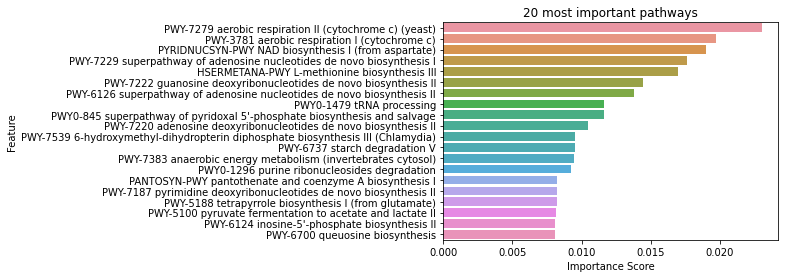

In [371]:
tree_feats_rf = tree_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_rf, k=20)

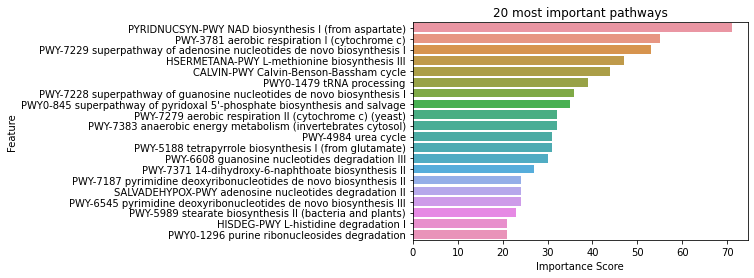

In [372]:
tree_feats_xgb = tree_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_xgb, k=20)

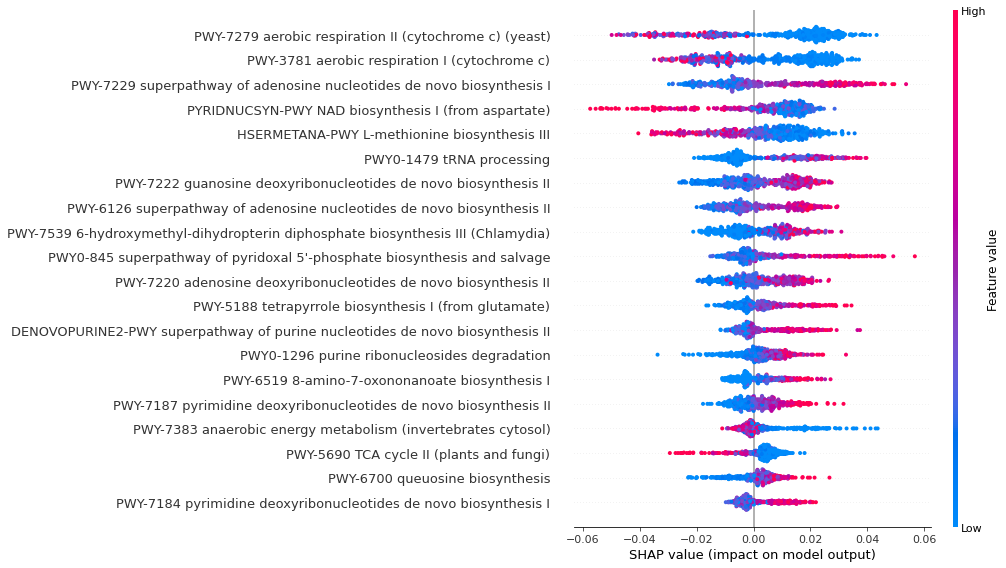

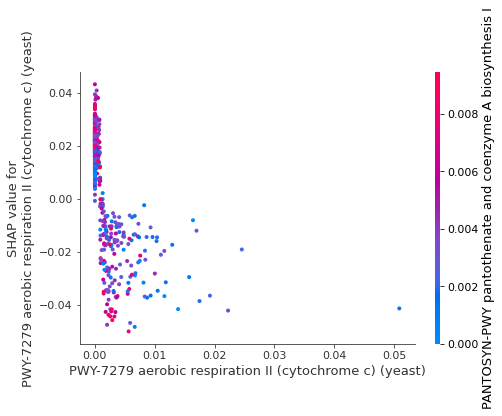

In [373]:
p_rf, shap_feats_rf = shap_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_rf, j=3)

In [374]:
p_rf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


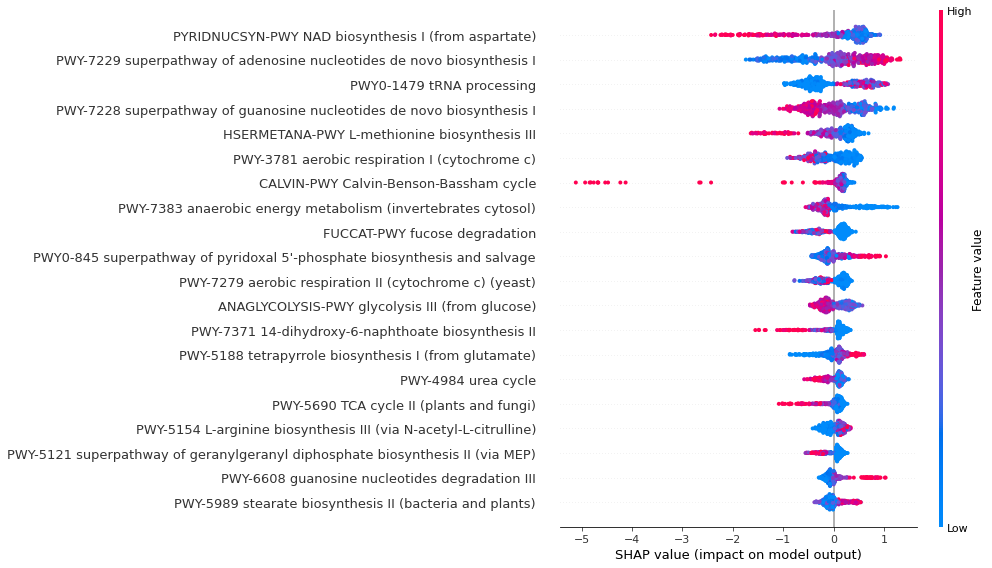

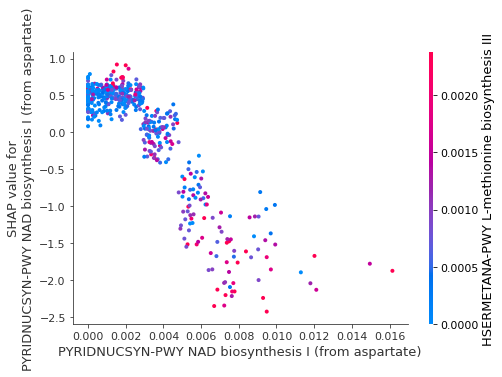

In [375]:
p_xgb, shap_feats_xgb = shap_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_xgb, j=3)

In [376]:
p_xgb

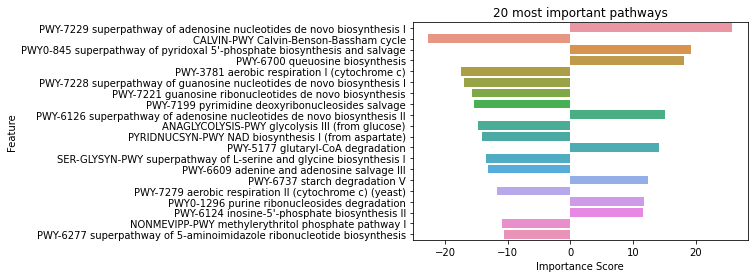

In [333]:
linear_feats_sgd = linear_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_sgd, j=20)

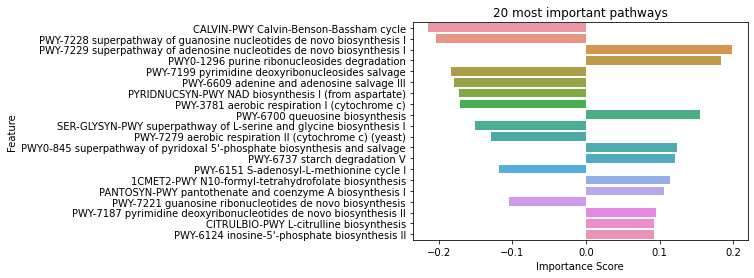

In [334]:
linear_feats_svc = linear_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_svc, j=20)

In [389]:
mutual_info_feat = []
for k in tqdm(range(10, 200, 10)):
    mutual_info_feat.append(mutual_info(X_train_temp[0].drop(columns=['Participant ID']),\
    np.array(y_train_temp[0].drop(columns=['Participant ID'])).ravel(), k))

100%|██████████| 19/19 [01:18<00:00,  4.13s/it]


### Feature selection and training models again

In [390]:
ALL_selected_features = {'tree': [], 'shap': [], 'mutual_info': [], 'tree_xgb': [], 'shap_xgb': [], \
                        'svc': [], 'sgd': []}
ALL_selected_features['mutual_info'] = list(mutual_info_feat)

for k in range(10, 200, 10):
    ALL_selected_features['tree'].append(bestktree(tree_feats_rf, k))
    ALL_selected_features['tree_xgb'].append(bestktree(tree_feats_xgb, k))
    
    ALL_selected_features['shap'].append(bestkshap(X_train_temp[0].drop(columns=['Participant ID']), shap_feats_rf, k))
    ALL_selected_features['shap_xgb'].append(bestkshap(X_train_temp[0].drop(columns=['Participant ID']), shap_feats_xgb, k))
    
    ALL_selected_features['svc'].append(bestklinear(linear_feats_svc, k))
    ALL_selected_features['sgd'].append(bestklinear(linear_feats_sgd, k))

In [401]:
f1_rf = {'all': [f1_0_rf, f1_1_rf], 'tree': [[], []], 'shap': [[], []],\
         'mi': [[], []]}

f1_xgb = {'all': [f1_0_xgb, f1_1_xgb], 'tree': [[], []], 'shap': [[], []],\
         'mi': [[], []]}

f1_sgd = {'all': [f1_0_sgd, f1_1_sgd], 'svc': [[], []], 'sgd': [[], []], 'mi': [[], []]}

f1_svc = {'all': [f1_0_svc, f1_1_svc], 'svc': [[], []], 'sgd': [[], []], 'mi': [[], []]}

for i in tqdm(range(19)):
    feats_tree = ALL_selected_features['tree'][i]
    feats_tree_xgb = ALL_selected_features['tree_xgb'][i]
    
    feats_shap = ALL_selected_features['shap'][i]
    feats_shap_xgb = ALL_selected_features['shap_xgb'][i]
    
    feats_mi = list(ALL_selected_features['mutual_info'][i])
    feats_svc = ALL_selected_features['svc'][i]
    feats_sgd = ALL_selected_features['sgd'][i]
    
    for ft, f in zip([feats_svc, feats_sgd, feats_mi], ['svc', 'sgd', 'mi']):
        ftc = ft.copy()
        ftc.extend(['Participant ID'])

        X_train_temp_sel = [X_train_temp[0][ftc]]
        X_test_temp_sel = [X_test_temp[0][ftc]]
        
        _, f1_0_sgd, f1_1_sgd = sgd(X_train_temp_sel, X_test_temp_sel, y_train_temp, y_test_temp, j=5, output=False, disable=True)
        _, f1_0_svc, f1_1_svc = svc(X_train_temp_sel, X_test_temp_sel, y_train_temp, y_test_temp, j=5, output=False, disable=True)
        
        f1_sgd[f][0].append(f1_0_sgd[0])
        f1_sgd[f][1].append(f1_1_sgd[0])
        
        f1_svc[f][0].append(f1_0_svc[0])
        f1_svc[f][1].append(f1_1_svc[0])
    
    for ft, f in zip([feats_tree, feats_shap, feats_mi], ['tree', 'shap', 'mi']):
        ftc = ft.copy()
        ftc.extend(['Participant ID'])

        X_train_temp_sel = [X_train_temp[0][ftc]]
        X_test_temp_sel = [X_test_temp[0][ftc]]
        
        _, f1_0_rf, f1_1_rf = rfc2(X_train_temp_sel, X_test_temp_sel, y_train_temp, y_test_temp, j=5, output=False, disable=True)
        
        f1_rf[f][0].append(f1_0_rf[0])
        f1_rf[f][1].append(f1_1_rf[0])
    
    for ft, f in zip([feats_tree_xgb, feats_shap_xgb, feats_mi], ['tree', 'shap', 'mi']):
        ftc = ft.copy()
        ftc.extend(['Participant ID'])

        X_train_temp_sel = [X_train_temp[0][ftc]]
        X_test_temp_sel = [X_test_temp[0][ftc]]
        
        _, f1_0_xgb, f1_1_xgb = xgboost2(X_train_temp_sel, X_test_temp_sel, y_train_temp, y_test_temp, j=5, output=False, disable=True)
        
        f1_xgb[f][0].append(f1_0_xgb[0])
        f1_xgb[f][1].append(f1_1_xgb[0])


  0%|          | 0/19 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.5641025641025641
Average best F1 for class 1:  0.711864406779661
Average best F1 for class 0:  0.5913043478260871
Average best F1 for class 1:  0.7374301675977653
Average best F1 for class 0:  0.5689655172413793
Average best F1 for class 1:  0.7191011235955055
Average best F1 for class 0:  0.608695652173913
Average best F1 for class 1:  0.7486033519553073
Average best F1 for class 0:  0.5196850393700787
Average best F1 for class 1:  0.6347305389221558


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.42
Average best F1 for class 1:  0.7010309278350516
Average best F1 for class 0:  0.6542056074766354
Average best F1 for class 1:  0.8021390374331551
Average best F1 for class 0:  0.6095238095238094
Average best F1 for class 1:  0.783068783068783
Average best F1 for class 0:  0.48936170212765956
Average best F1 for class 1:  0.76
Average best F1 for class 0:  0.5436893203883496
Average best F1 for class 1:  0.7539267015706805
Average best F1 for class 0:  0.5871559633027523
Average best F1 for class 1:  0.7567567567567568


  5%|▌         | 1/19 [00:06<01:56,  6.50s/it]

Average best F1 for class 0:  0.4337349397590361
Average best F1 for class 1:  0.7772511848341233
Average best F1 for class 0:  0.6534653465346534
Average best F1 for class 1:  0.8186528497409326
Average best F1 for class 0:  0.6548672566371682
Average best F1 for class 1:  0.7845303867403315
Average best F1 for class 0:  0.6034482758620688
Average best F1 for class 1:  0.7415730337078652
Average best F1 for class 0:  0.6095238095238094
Average best F1 for class 1:  0.783068783068783
Average best F1 for class 0:  0.5426356589147286
Average best F1 for class 1:  0.6424242424242426
Average best F1 for class 0:  0.6193548387096774
Average best F1 for class 1:  0.5755395683453237
Average best F1 for class 0:  0.6728971962616822
Average best F1 for class 1:  0.8128342245989305
Average best F1 for class 0:  0.5961538461538461
Average best F1 for class 1:  0.7789473684210526
Average best F1 for class 0:  0.5148514851485149
Average best F1 for class 1:  0.7461139896373057
Average best F1 for c

 11%|█         | 2/19 [00:13<01:53,  6.70s/it]

Average best F1 for class 0:  0.49411764705882355
Average best F1 for class 1:  0.7942583732057418
Average best F1 for class 0:  0.6526315789473685
Average best F1 for class 1:  0.8341708542713568
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.788888888888889
Average best F1 for class 0:  0.6521739130434783
Average best F1 for class 1:  0.8415841584158416
Average best F1 for class 0:  0.6521739130434783
Average best F1 for class 1:  0.8415841584158416
Average best F1 for class 0:  0.5343511450381679
Average best F1 for class 1:  0.6257668711656441
Average best F1 for class 0:  0.5652173913043479
Average best F1 for class 1:  0.801980198019802
Average best F1 for class 0:  0.6915887850467289
Average best F1 for class 1:  0.8235294117647058
Average best F1 for class 0:  0.6168224299065421
Average best F1 for class 1:  0.7807486631016043
Average best F1 for class 0:  0.5348837209302325
Average best F1 for class 1:  0.8076923076923076
Average best F1 for c

 16%|█▌        | 3/19 [00:20<01:52,  7.04s/it]

Average best F1 for class 0:  0.4444444444444445
Average best F1 for class 1:  0.8198198198198199
Average best F1 for class 0:  0.6470588235294118
Average best F1 for class 1:  0.8125
Average best F1 for class 0:  0.6391752577319587
Average best F1 for class 1:  0.8223350253807107
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8457711442786069
Average best F1 for class 0:  0.6597938144329897
Average best F1 for class 1:  0.8324873096446701
Average best F1 for class 0:  0.5384615384615384
Average best F1 for class 1:  0.6341463414634148
Average best F1 for class 0:  0.6376811594202899
Average best F1 for class 1:  0.6794871794871796
Average best F1 for class 0:  0.6037735849056605
Average best F1 for class 1:  0.7765957446808511
Average best F1 for class 0:  0.6486486486486487
Average best F1 for class 1:  0.7868852459016393
Average best F1 for class 0:  0.5853658536585367
Average best F1 for class 1:  0.8396226415094339
Average best F1 for class 0:  0.

 21%|██        | 4/19 [00:28<01:48,  7.25s/it]

Average best F1 for class 0:  0.6019417475728156
Average best F1 for class 1:  0.7853403141361257
Average best F1 for class 0:  0.6551724137931034
Average best F1 for class 1:  0.7752808988764046
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.7978142076502733
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8457711442786069
Average best F1 for class 0:  0.6542056074766354
Average best F1 for class 1:  0.8021390374331551
Average best F1 for class 0:  0.5757575757575758
Average best F1 for class 1:  0.654320987654321
Average best F1 for class 0:  0.5757575757575758
Average best F1 for class 1:  0.654320987654321
Average best F1 for class 0:  0.611764705882353
Average best F1 for class 1:  0.8421052631578948
Average best F1 for class 0:  0.6972477064220183
Average best F1 for class 1:  0.8216216216216217
Average best F1 for class 0:  0.5416666666666667
Average best F1 for class 1:  0.7777777777777778
Average best F1 for cla

 26%|██▋       | 5/19 [00:35<01:43,  7.38s/it]

Average best F1 for class 0:  0.5121951219512195
Average best F1 for class 1:  0.8113207547169812
Average best F1 for class 0:  0.6526315789473685
Average best F1 for class 1:  0.8341708542713568
Average best F1 for class 0:  0.6190476190476191
Average best F1 for class 1:  0.8476190476190476
Average best F1 for class 0:  0.6451612903225806
Average best F1 for class 1:  0.835820895522388
Average best F1 for class 0:  0.6436781609195403
Average best F1 for class 1:  0.8502415458937198
Average best F1 for class 0:  0.5581395348837209
Average best F1 for class 1:  0.6545454545454544
Average best F1 for class 0:  0.6141732283464567
Average best F1 for class 1:  0.7065868263473053
Average best F1 for class 0:  0.6605504587155964
Average best F1 for class 1:  0.7999999999999999
Average best F1 for class 0:  0.6095238095238094
Average best F1 for class 1:  0.783068783068783
Average best F1 for class 0:  0.5833333333333334
Average best F1 for class 1:  0.7979797979797979
Average best F1 for cl

 32%|███▏      | 6/19 [00:43<01:38,  7.57s/it]

Average best F1 for class 0:  0.5894736842105263
Average best F1 for class 1:  0.8040201005025126
Average best F1 for class 0:  0.6458333333333333
Average best F1 for class 1:  0.8282828282828283
Average best F1 for class 0:  0.6597938144329897
Average best F1 for class 1:  0.8324873096446701
Average best F1 for class 0:  0.673469387755102
Average best F1 for class 1:  0.8367346938775511
Average best F1 for class 0:  0.6736842105263158
Average best F1 for class 1:  0.8442211055276382
Average best F1 for class 0:  0.609271523178808
Average best F1 for class 1:  0.5874125874125874
Average best F1 for class 0:  0.4835164835164835
Average best F1 for class 1:  0.768472906403941
Average best F1 for class 0:  0.6373626373626373
Average best F1 for class 1:  0.8374384236453202
Average best F1 for class 0:  0.6181818181818182
Average best F1 for class 1:  0.7717391304347825
Average best F1 for class 0:  0.5185185185185185
Average best F1 for class 1:  0.8169014084507042
Average best F1 for cla

 37%|███▋      | 7/19 [00:58<01:56,  9.72s/it]

Average best F1 for class 0:  0.5054945054945055
Average best F1 for class 1:  0.7783251231527093
Average best F1 for class 0:  0.6458333333333333
Average best F1 for class 1:  0.8282828282828283
Average best F1 for class 0:  0.6530612244897959
Average best F1 for class 1:  0.826530612244898
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8383838383838385
Average best F1 for class 0:  0.6526315789473685
Average best F1 for class 1:  0.8341708542713568
Average best F1 for class 0:  0.5692307692307692
Average best F1 for class 1:  0.6585365853658536
Average best F1 for class 0:  0.48192771084337355
Average best F1 for class 1:  0.7962085308056872
Average best F1 for class 0:  0.6136363636363635
Average best F1 for class 1:  0.8349514563106796
Average best F1 for class 0:  0.574712643678161
Average best F1 for class 1:  0.821256038647343
Average best F1 for class 0:  0.4615384615384615
Average best F1 for class 1:  0.8055555555555555
Average best F1 for cl

 42%|████▏     | 8/19 [01:10<01:55, 10.50s/it]

Average best F1 for class 0:  0.5172413793103449
Average best F1 for class 1:  0.6853932584269663
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8457711442786069
Average best F1 for class 0:  0.631578947368421
Average best F1 for class 1:  0.8241206030150754
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8383838383838385
Average best F1 for class 0:  0.6516853932584269
Average best F1 for class 1:  0.848780487804878
Average best F1 for class 0:  0.6074074074074074
Average best F1 for class 1:  0.6666666666666667
Average best F1 for class 0:  0.5714285714285714
Average best F1 for class 1:  0.7085714285714286
Average best F1 for class 0:  0.6292134831460674
Average best F1 for class 1:  0.8390243902439024
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.788888888888889
Average best F1 for class 0:  0.5301204819277109
Average best F1 for class 1:  0.8151658767772512
Average best F1 for cla

 47%|████▋     | 9/19 [01:23<01:53, 11.32s/it]

Average best F1 for class 0:  0.5892857142857143
Average best F1 for class 1:  0.7472527472527472
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8457711442786069
Average best F1 for class 0:  0.625
Average best F1 for class 1:  0.8181818181818183
Average best F1 for class 0:  0.673469387755102
Average best F1 for class 1:  0.8367346938775511
Average best F1 for class 0:  0.6516853932584269
Average best F1 for class 1:  0.848780487804878
Average best F1 for class 0:  0.6363636363636364
Average best F1 for class 1:  0.782608695652174
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.7701149425287356
Average best F1 for class 0:  0.6181818181818182
Average best F1 for class 1:  0.7717391304347825
Average best F1 for class 0:  0.6206896551724138
Average best F1 for class 1:  0.8405797101449275
Average best F1 for class 0:  0.6019417475728156
Average best F1 for class 1:  0.7853403141361257
Average best F1 for class 0:  0.6122

 53%|█████▎    | 10/19 [01:31<01:34, 10.46s/it]

Average best F1 for class 0:  0.6055045871559633
Average best F1 for class 1:  0.7675675675675676
Average best F1 for class 0:  0.6808510638297872
Average best F1 for class 1:  0.8499999999999999
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8383838383838385
Average best F1 for class 0:  0.6597938144329897
Average best F1 for class 1:  0.8324873096446701
Average best F1 for class 0:  0.6292134831460674
Average best F1 for class 1:  0.8390243902439024
Average best F1 for class 0:  0.6238532110091742
Average best F1 for class 1:  0.7783783783783784
Average best F1 for class 0:  0.6341463414634146
Average best F1 for class 1:  0.7368421052631579
Average best F1 for class 0:  0.5740740740740742
Average best F1 for class 1:  0.7526881720430106
Average best F1 for class 0:  0.6930693069306932
Average best F1 for class 1:  0.839378238341969
Average best F1 for class 0:  0.5609756097560976
Average best F1 for class 1:  0.8301886792452831
Average best F1 for c

 58%|█████▊    | 11/19 [01:40<01:18,  9.82s/it]

Average best F1 for class 0:  0.6055045871559633
Average best F1 for class 1:  0.7675675675675676
Average best F1 for class 0:  0.6808510638297872
Average best F1 for class 1:  0.8499999999999999
Average best F1 for class 0:  0.6304347826086958
Average best F1 for class 1:  0.8316831683168318
Average best F1 for class 0:  0.6593406593406593
Average best F1 for class 1:  0.8472906403940886
Average best F1 for class 0:  0.6526315789473685
Average best F1 for class 1:  0.8341708542713568
Average best F1 for class 0:  0.672566371681416
Average best F1 for class 1:  0.7955801104972376
Average best F1 for class 0:  0.6271186440677967
Average best F1 for class 1:  0.75


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6250000000000001
Average best F1 for class 1:  0.7692307692307692
Average best F1 for class 0:  0.6095238095238094
Average best F1 for class 1:  0.783068783068783


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.5714285714285714
Average best F1 for class 1:  0.7857142857142857
Average best F1 for class 0:  0.5283018867924528
Average best F1 for class 1:  0.7340425531914894
Average best F1 for class 0:  0.574712643678161
Average best F1 for class 1:  0.821256038647343


 63%|██████▎   | 12/19 [01:49<01:07,  9.59s/it]

Average best F1 for class 0:  0.5909090909090909
Average best F1 for class 1:  0.8252427184466019
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8457711442786069
Average best F1 for class 0:  0.6808510638297872
Average best F1 for class 1:  0.8499999999999999
Average best F1 for class 0:  0.6444444444444445
Average best F1 for class 1:  0.8431372549019608
Average best F1 for class 0:  0.6153846153846153
Average best F1 for class 1:  0.8275862068965518
Average best F1 for class 0:  0.6534653465346534
Average best F1 for class 1:  0.8186528497409326
Average best F1 for class 0:  0.6476190476190475
Average best F1 for class 1:  0.8042328042328042
Average best F1 for class 0:  0.5609756097560976
Average best F1 for class 1:  0.8301886792452831


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6792452830188679
Average best F1 for class 1:  0.8191489361702127


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6
Average best F1 for class 1:  0.7608695652173914
Average best F1 for class 0:  0.5794392523364486
Average best F1 for class 1:  0.7593582887700534
Average best F1 for class 0:  0.5567010309278351
Average best F1 for class 1:  0.7817258883248731


 68%|██████▊   | 13/19 [01:58<00:56,  9.44s/it]

Average best F1 for class 0:  0.5957446808510639
Average best F1 for class 1:  0.8099999999999999
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8457711442786069
Average best F1 for class 0:  0.6170212765957447
Average best F1 for class 1:  0.8200000000000001
Average best F1 for class 0:  0.6516853932584269
Average best F1 for class 1:  0.848780487804878
Average best F1 for class 0:  0.6451612903225806
Average best F1 for class 1:  0.835820895522388
Average best F1 for class 0:  0.640625
Average best F1 for class 1:  0.7228915662650602
Average best F1 for class 0:  0.626865671641791
Average best F1 for class 1:  0.6875


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6481481481481481
Average best F1 for class 1:  0.7956989247311828
Average best F1 for class 0:  0.6728971962616822
Average best F1 for class 1:  0.8128342245989305
Average best F1 for class 0:  0.5871559633027523
Average best F1 for class 1:  0.7567567567567568
Average best F1 for class 0:  0.5750000000000001
Average best F1 for class 1:  0.8411214953271028
Average best F1 for class 0:  0.6476190476190475
Average best F1 for class 1:  0.8042328042328042


 74%|███████▎  | 14/19 [02:07<00:46,  9.37s/it]

Average best F1 for class 0:  0.6391752577319587
Average best F1 for class 1:  0.8223350253807107
Average best F1 for class 0:  0.6808510638297872
Average best F1 for class 1:  0.8499999999999999
Average best F1 for class 0:  0.6236559139784946
Average best F1 for class 1:  0.8258706467661691
Average best F1 for class 0:  0.6516853932584269
Average best F1 for class 1:  0.848780487804878
Average best F1 for class 0:  0.6382978723404255
Average best F1 for class 1:  0.8300000000000002
Average best F1 for class 0:  0.6611570247933884
Average best F1 for class 1:  0.7630057803468209
Average best F1 for class 0:  0.676923076923077
Average best F1 for class 1:  0.7439024390243902


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6590909090909091
Average best F1 for class 1:  0.8543689320388349


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6542056074766354
Average best F1 for class 1:  0.8021390374331551
Average best F1 for class 0:  0.6428571428571428
Average best F1 for class 1:  0.7802197802197802
Average best F1 for class 0:  0.5660377358490565
Average best F1 for class 1:  0.7553191489361704
Average best F1 for class 0:  0.6542056074766354
Average best F1 for class 1:  0.8021390374331551


 79%|███████▉  | 15/19 [02:17<00:37,  9.46s/it]

Average best F1 for class 0:  0.5591397849462366
Average best F1 for class 1:  0.7960199004975125
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8457711442786069
Average best F1 for class 0:  0.6170212765957447
Average best F1 for class 1:  0.8200000000000001
Average best F1 for class 0:  0.66
Average best F1 for class 1:  0.8247422680412372
Average best F1 for class 0:  0.6451612903225806
Average best F1 for class 1:  0.835820895522388
Average best F1 for class 0:  0.6724137931034483
Average best F1 for class 1:  0.7865168539325842
Average best F1 for class 0:  0.6614173228346457
Average best F1 for class 1:  0.7425149700598802


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6329113924050633
Average best F1 for class 1:  0.8651162790697675
Average best F1 for class 0:  0.6481481481481481
Average best F1 for class 1:  0.7956989247311828


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6153846153846153
Average best F1 for class 1:  0.7894736842105263
Average best F1 for class 0:  0.6363636363636364
Average best F1 for class 1:  0.782608695652174
Average best F1 for class 0:  0.6238532110091742
Average best F1 for class 1:  0.7783783783783784


 84%|████████▍ | 16/19 [02:26<00:28,  9.51s/it]

Average best F1 for class 0:  0.6097560975609756
Average best F1 for class 1:  0.8490566037735849
Average best F1 for class 0:  0.6292134831460674
Average best F1 for class 1:  0.8390243902439024
Average best F1 for class 0:  0.6236559139784946
Average best F1 for class 1:  0.8258706467661691
Average best F1 for class 0:  0.6516853932584269
Average best F1 for class 1:  0.848780487804878
Average best F1 for class 0:  0.6236559139784946
Average best F1 for class 1:  0.8258706467661691
Average best F1 for class 0:  0.6526315789473685
Average best F1 for class 1:  0.8341708542713568
Average best F1 for class 0:  0.6213592233009709
Average best F1 for class 1:  0.7958115183246073


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.7978142076502733


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6422018348623854
Average best F1 for class 1:  0.7891891891891891


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.5904761904761905
Average best F1 for class 1:  0.7724867724867726
Average best F1 for class 0:  0.5871559633027523
Average best F1 for class 1:  0.7567567567567568
Average best F1 for class 0:  0.6355140186915887
Average best F1 for class 1:  0.7914438502673796


 89%|████████▉ | 17/19 [02:36<00:19,  9.56s/it]

Average best F1 for class 0:  0.6285714285714286
Average best F1 for class 1:  0.7936507936507936
Average best F1 for class 0:  0.6516853932584269
Average best F1 for class 1:  0.848780487804878
Average best F1 for class 0:  0.6304347826086958
Average best F1 for class 1:  0.8316831683168318
Average best F1 for class 0:  0.6516853932584269
Average best F1 for class 1:  0.848780487804878
Average best F1 for class 0:  0.6236559139784946
Average best F1 for class 1:  0.8258706467661691
Average best F1 for class 0:  0.6881720430107526
Average best F1 for class 1:  0.8557213930348259
Average best F1 for class 0:  0.6464646464646464
Average best F1 for class 1:  0.8205128205128205


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6324786324786325
Average best F1 for class 1:  0.7570621468926553
Average best F1 for class 0:  0.6226415094339622
Average best F1 for class 1:  0.7872340425531914
Average best F1 for class 0:  0.672566371681416
Average best F1 for class 1:  0.7955801104972376
Average best F1 for class 0:  0.6226415094339622
Average best F1 for class 1:  0.7872340425531914
Average best F1 for class 0:  0.6851851851851852
Average best F1 for class 1:  0.8172043010752688


 95%|█████████▍| 18/19 [02:46<00:09,  9.67s/it]

Average best F1 for class 0:  0.6168224299065421
Average best F1 for class 1:  0.7807486631016043
Average best F1 for class 0:  0.6516853932584269
Average best F1 for class 1:  0.848780487804878
Average best F1 for class 0:  0.6236559139784946
Average best F1 for class 1:  0.8258706467661691
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8529411764705883
Average best F1 for class 0:  0.6222222222222223
Average best F1 for class 1:  0.8333333333333334
Average best F1 for class 0:  0.6666666666666666
Average best F1 for class 1:  0.8457711442786069
Average best F1 for class 0:  0.6915887850467289
Average best F1 for class 1:  0.8235294117647058


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6285714285714286
Average best F1 for class 1:  0.7936507936507936


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6095238095238094
Average best F1 for class 1:  0.783068783068783


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.6037735849056605
Average best F1 for class 1:  0.7765957446808511
Average best F1 for class 0:  0.6355140186915887
Average best F1 for class 1:  0.7914438502673796
Average best F1 for class 0:  0.5904761904761905
Average best F1 for class 1:  0.7724867724867726


100%|██████████| 19/19 [02:56<00:00,  9.28s/it]

Average best F1 for class 0:  0.5925925925925926
Average best F1 for class 1:  0.7634408602150539


### Model performance with respect to number of features

In [402]:
def f1_plot(f1_model, title, markers):
    X = list(range(10, 200, 10))
#     X = [30, 35, 40]
    
    plt.figure()
    
    plt.hlines(f1_model['all'][0], xmin=10, xmax=200, colors='green', linestyles='solid', label='all features, class 0')
    plt.hlines(f1_model['all'][1], xmin=10, xmax=200, colors='yellow', linestyles='solid', label='all features, class 1')
    
    for f, m in zip(list(f1_model.keys())[1:], markers):
#         print(len(X), len(f1_model[f][0]))
        plt.plot(X, f1_model[f][0], label=f'{f}, class 0', linestyle=m, color='blue')
        plt.plot(X, f1_model[f][1], label=f'{f}, class 1', linestyle=m, color='red')
    
    plt.legend(bbox_to_anchor=(1.05, 1.025))
    plt.xlabel('Number of features')
    plt.ylabel('F1-score')
    plt.title(f'{title} F1 scores')
    plt.figure()
    
    plt.show()

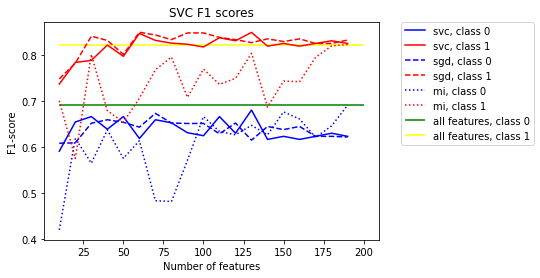

<Figure size 432x288 with 0 Axes>

In [403]:
f1_plot(f1_svc, 'SVC', markers = ['-', '--', ':'])

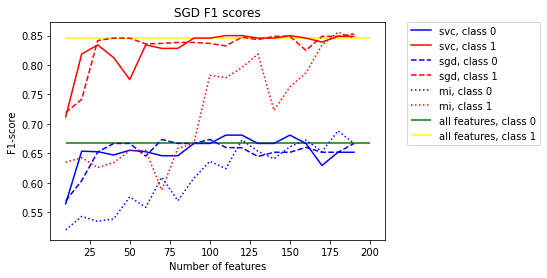

<Figure size 432x288 with 0 Axes>

In [404]:
f1_plot(f1_sgd, 'SGD', markers = ['-', '--', ':'])

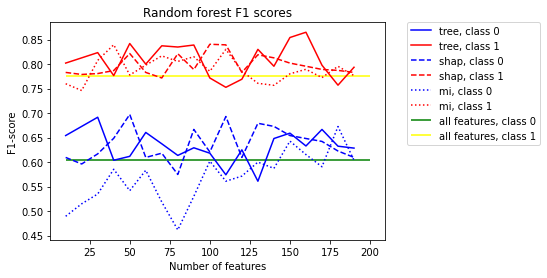

<Figure size 432x288 with 0 Axes>

In [405]:
f1_plot(f1_rf, 'Random forest', markers = ['-', '--', ':'])

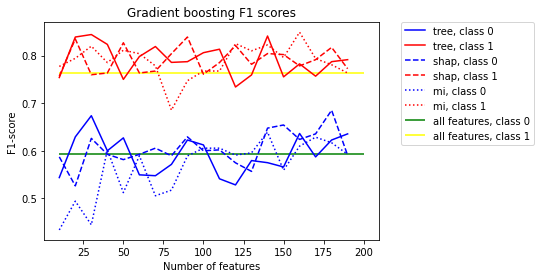

<Figure size 432x288 with 0 Axes>

In [406]:
f1_plot(f1_xgb, 'Gradient boosting', markers = ['-', '--', ':'])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2609b90e-251e-426c-b0d0-07040df3c126' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>